# 链接仪器

In [78]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy, visa
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from easydl import clear_output
from sklearn.cluster import KMeans
# from qulab import wavepoint
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new
# from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
opt = imp.reload(opt)
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
# mn = imp.reload(measureroutine_new)
# wf = imp.reload(wavepoint)

In [25]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
afg= await connect('AFG')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
# ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
# psg104 = await connect('PSG104')
# psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
afg = await connect('AFG')
att3 = await connect('Att3')
att4 = await connect('Att4')
att5 = await connect('Att5')
att6 = await connect('Att6')
att7 = await connect('Att7')
att8 = await connect('Att8')
att9 = await connect('Att9')
# # #pna = await connect('PNA')

In [352]:
await awg133.query('*IDN?')

'TEKTRONIX,AWG5208,B010153,FV:6.1.0054.0\n'

# redis测试

In [75]:
import redis

# 普通连接
conn = redis.Redis(host="10.122.7.20",port=6379)
conn.set("x1","hello",ex=1) # ex代表seconds，px代表ms
val = conn.get("x1")
print(val)

b'hello'


# 设置TrigB

In [31]:
import visa

rm = visa.ResourceManager()
psg101=rm.open_resource('TCPIP::10.122.7.101')
psg101.query(':OUTP?')

'0\r\n'

In [7]:
afg.write('SOUR%d:VOLT:AMPL %f'%(1,5))

(26, <StatusCode.success: 0>)

In [4]:
await afg.reset()
await asyncio.sleep(2)
await afg.setValue('Output','ON',ch=1)
await afg.setValue('Function','Pulse',ch=1)
await afg.setValue('Pulse Period',110e-6,ch=1)
await afg.setValue('Pulse Width',1e-6,ch=1)
await afg.setValue('Amplitude',5,ch=1)
await afg.setValue('Offset',0,ch=1)

In [5]:
for i in range(20):
    await afg.write('*TRG')
    time.sleep(1)

# qubit工作点

In [50]:
# freqall = np.array([6.505,6.517,6.53,6.542,6.559,6.571,6.587,6.601,6.6045,6.63])*1e9
# freqall = np.array([6.451,6.466,6.478,6.494,6.51,6.508,6.516,6.534,6.563,6.576])*1e9
freqall = np.array([6.501,6.515,6.533,6.545,6.56,6.574,6.587,6.603,6.618,6.623])*1e9
# freqall = freqall[::-1]
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}
atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex','alpha',\
             'power_ex','power_rabi','pi_len','T1','state','timing']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

# jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=-0.273,f_ex=2*6.58e9+2e6,power_ex=22.1) #power=-2.1

In [36]:
measure.freqall = f_cavity

In [6]:
jpa = qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-0.27,f_ex=2*6.58e9+2e6,power_ex=22.2) #power=-2.1

## 保存工作点

In [41]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\qubit_state.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0825\QubitState\qubitstate_20200825160920.npz


In [64]:
q6 = q6._replace(f_lo=np.array([6.571e9]))

## 提取工作点

In [51]:
fl = np.loadtxt(r'D:\skzhao\file_name\qubit_state.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0825\QubitState\qubitstate_20200825180630.npz


In [49]:
q1

qubit(q_name='q1', inst={'dc': 'dc03', 'z_awg': 'awg131', 'z_ch': [8], 'ex_awg': 'awg133', 'ex_ch': [3, 7], 'ex_lo': 'psg_ex1', 'com': 'com3'}, T_bias=[1.37, -0.136], specfunc=0.541605287359199*sqrt(Abs(cos(3.70594731677801*x + 2.92055965298964))) + 3.35424619070488, bias=0, zpulse=None, f_lo=array([6.535e+09]), delta=array([50000000.]), f_ex=array([5.161e+09]), delta_ex=array([1.1e+08]), alpha=269800000.0, power_ex=60, power_rabi=30, pi_len=16, T1=23016.178849233776, state=[{'q5': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q2': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': 0.78, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q10': {'offs

# 提取IQ-Mixer配置参数

In [6]:
fl = np.loadtxt(r'D:\skzhao\file_name\iqmixer_state.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)

atributte = ['q_name','alpha_read','alpha_ch1','alpha_ch2','alpha_ch3','alpha_ch4','alpha_ch5',\
            'beta_read','beta_ch1','beta_ch2','beta_ch3','beta_ch4','beta_ch5']
Iqmixer = namedtuple('Iqmixer',atributte,defaults=[{} for i in range(12)])

iqm = Iqmixer(q_name='Iqm') #power=-2.1

def dict2tuple(q):
    global iqm
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        iqm = Iqmixer(*attr)

dict2tuple(data['state'])
# print(f,iqm)

In [7]:
iqm.alpha_read

{}

In [414]:
ch_I, ch_Q, offset_I, offset_Q = 5,6,-3.700e-02, -5.000e-02
awg = awg132
await awg.setValue('Offset',offset_I,ch=ch_I)
await awg.setValue('Offset',offset_Q,ch=ch_Q)

## 保存提取全局变量

In [433]:
cw.saveStatus(fname='D:/status.obj')

In [5]:
cw.loadStatus(fname='D:/status.obj')

# 指定仪器

In [26]:
psg_lo = psg105
psg_ex1 = psg106
psg_trans = psg230
# psg_ex2 = psg106
# psg_ex3 = psg103
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_trans':psg_trans,'psg_pump':psg_pump}
ats = ats18
awg_trig = awg100
dc = {'q8':dc01,'q1':dc02,'q7':dc03,'q2':dc05,'jpa':dc06,\
      'q6':dc07,'q4':dc08,'q5':dc11,'q3':dc15,'q9':dc20,'q10':dc10}
#awg = awg132
attinst = {'com3':att3,'com4':att4,'com5':att5,'com6':att6,'com7':att7,'com8':att8,'com9':att9}
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133}

In [273]:
measure.dc = dc

In [15]:
measure.dc = dc

In [156]:
await psg106.query('syst:err?')

'0,"No error"\n'

## 测量类

In [9]:
measure = mr.common(f_cavity,ats,dc,psg,awg_list,attinst,jpa,[q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

# 初始化及同步AWG

In [77]:
await mr.resetAwg([awg131,awg132,awg133,awg134])

In [9]:
await mr.awgSync(measure)

In [23]:
await att9.set_att(9)

# 信号检查

In [79]:
# delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
#        9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
# f_lo, delta, n = await mr.resn(f)
delta = np.array([50e6])
await cw.modulation_read(measure,delta,tdelay=1200)
# await mr.ats_setup(ats,delta,l=180+128)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

## 读出信号相位噪声

Output()

<IPython.core.display.Javascript object>


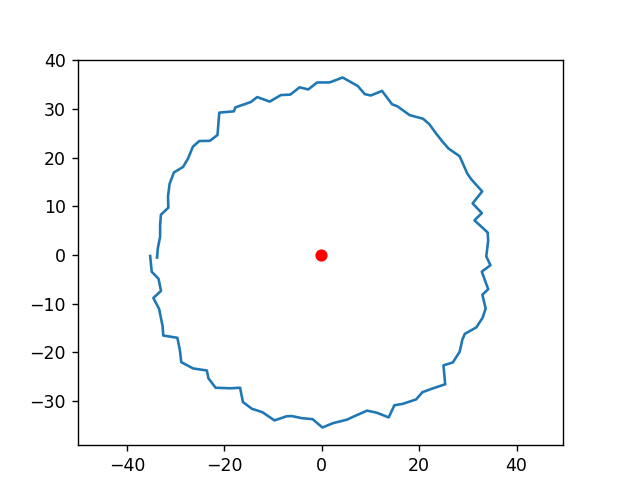

In [136]:
phase = np.linspace(0,2*np.pi,101)
job = Job(mr.rPhase, (measure,phase), tags=['phase noise'], max=len(phase))
pp, sp = await job.done()
plt.figure(figsize=(5,4))
plt.plot(np.real(sp[:,0]),np.imag(sp[:,0]))
plt.plot(np.mean(np.real(sp[:,0])),np.mean(np.imag(sp[:,0])),'ro')
plt.axis('equal')
plt.show()

In [34]:
f_list = await ats.setValue('repeats',201)

In [70]:
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [76]:
await psg_lo.setValue('Frequency',6.56e9)

## 复平面信号

<IPython.core.display.Javascript object>


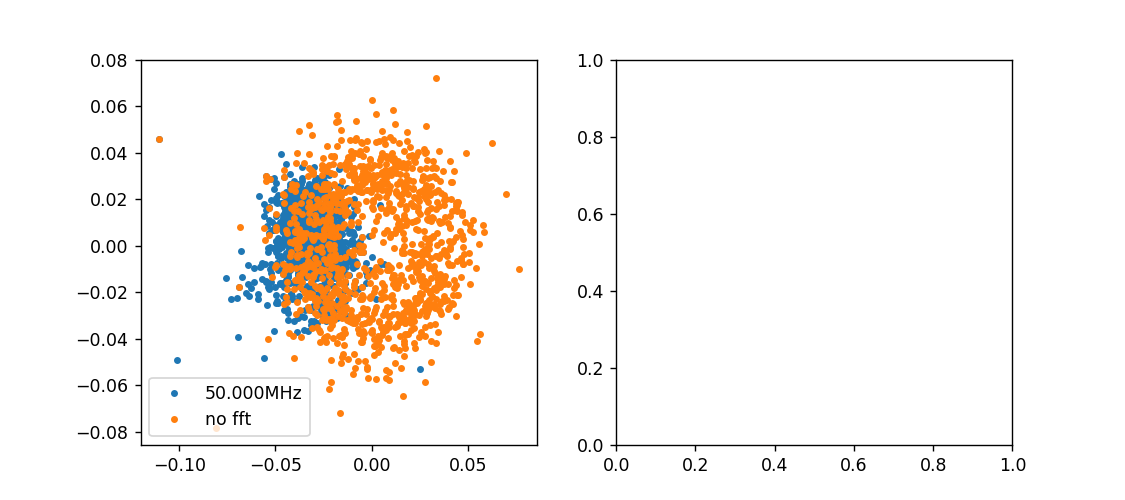

In [137]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
await psg_ex1.setValue('Output','OFF')
await mr.jpa_switch(measure,state='OFF')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB, ch_I, ch_Q = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=False,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

<IPython.core.display.Javascript object>


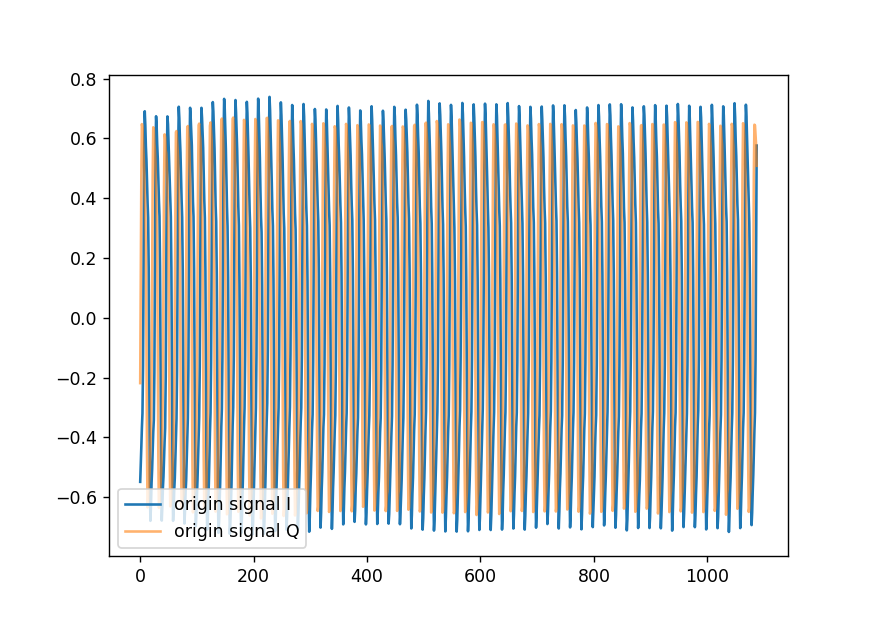

In [26]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex1'].setValue('Output','OFF')
for i in range(1):
    chA, chB, ch_I, ch_Q = await ats.getTraces(hilbert=False,is2ch=False)
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


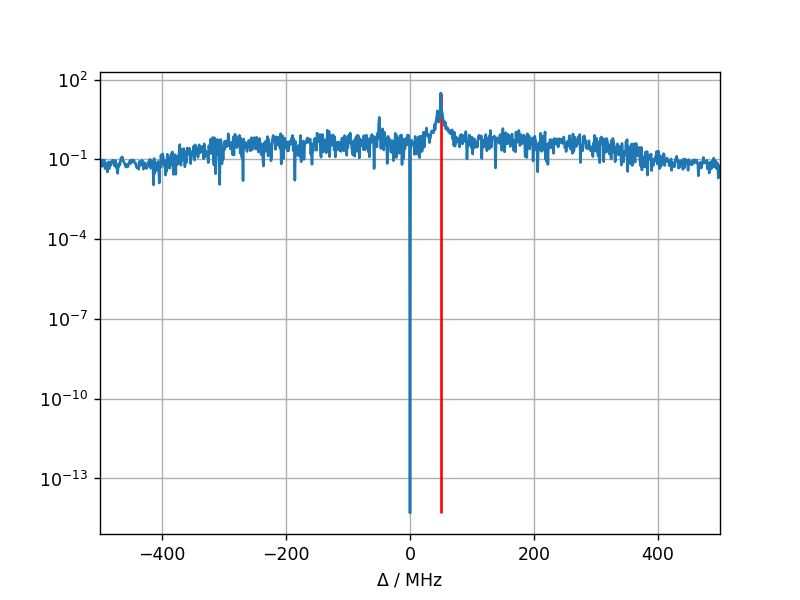

In [139]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

# 仪器状态

In [71]:
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

In [57]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

q5      q4      q8      q6      q3      q2      q1      q7  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        0       0       0       0       0       0       0       0   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

            jpa     q10      q9        psg_lo       psg_ex1    psg_trans  \
error        +0      +0      +0             0             0            0   
freq        NaN     NaN     NaN   6.611950GHz   5.723300GHz  5.999000GHz   
load     high Z  high Z  high Z           NaN           NaN          NaN   
mform       NaN     NaN     NaN           EXT           EXT          EXT   
moutput     NaN     NaN     NaN             0             0            1   
offset        0       0       0           NaN           NaN          NaN   
output      NaN     NaN     NaN             0             0            0   
power       NaN     NaN     NaN  18.000000dBm  15.000000dBm  0.000000dBm   

            psg_pump  
error              0  
freq     2.000000GHz  
load             NaN  
mform         EXT2\r  
moutput          0\r  
offset           NaN  
output           0\r  
power    0.000000dBm

In [159]:
10*np.log10(3)

4.771212547196624

In [92]:
await mr.RecoverInst(measure,state)

In [75]:
await psg_trans.setValue('Moutput','ON')

In [126]:
await psg_lo.setValue('Power',18)

In [18]:
await psg_lo.setValue('Frequency',6.5e9)

In [384]:
measure.delta,measure.base,measure.readlen = q3.state[1:]
await mr.RecoverInst(measure,state=q3.state[0])

In [442]:
for i in range(100):
    await psg_lo.query('syst:err?')

In [17]:
for i in dc:
    await dc[i].setValue('Load','High')

In [148]:
10*np.log10(3)

4.771212547196624

# S21

Output()

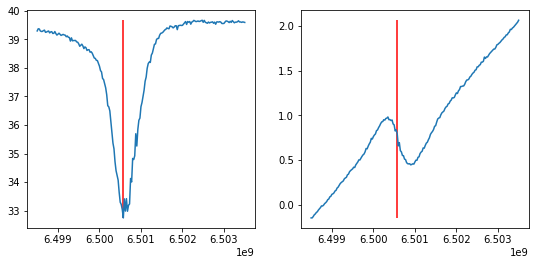

In [43]:
q_target = q1
freq = np.linspace(6.4,6.65,1001)*1e9 + 50e6
tag = q_target.q_name
await measure.attinst['com8'].set_att(30)
# await mr.jpa_switch(measure,state='ON')
f_lo, delta, n, f_res,base,f_s21, s_s21 = await mr.again(q_target,measure,True)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [155]:
await att8.query_att()

In [44]:
f_lo-measure.delta

array([6.500575e+09])

In [100]:
q10 = q10._replace(f_lo=np.array([6.576e9]))

In [117]:
measure.delta

array([4.4096e+08, 2.3420e+08, 1.4708e+08, 1.4608e+08, 1.2680e+08,
       1.2188e+08, 1.0292e+08, 6.3120e+07, 5.8080e+07, 5.0000e+07])

In [18]:
await dc10.DC(-0.9)
await dc11.DC(0)

# 读取信号强度随时间变化

Output()

<IPython.core.display.Javascript object>


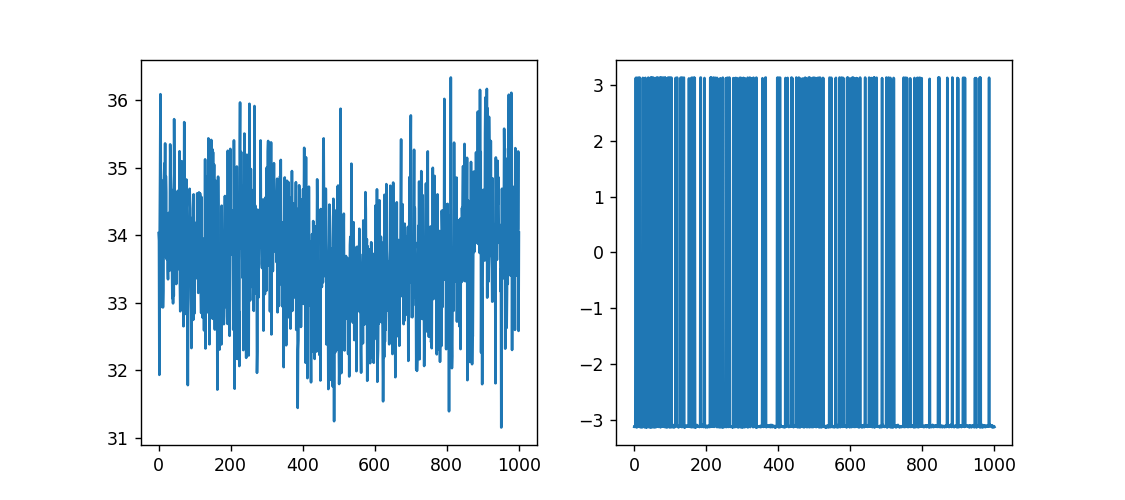

In [140]:
# await measure.attinst['com8'].set_att(20)
await psg_lo.setValue('Output','ON')
# await psg['psg_trans'].setValue('Output','ON')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
# await mr.jpa_switch(measure,state='OFF')
job = Job(mr.test, (measure,1001), tags=['time varing of signal'], max=1001)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,np.abs(s_s21))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [96]:
np.mean(np.abs(s_s21))/np.std(s_s21)

10.166608793708301

In [15]:
%matplotlib notebook

# S21vsFlux

In [46]:
bits = [q1,q3,q5,q6,q8,q10]
current = np.linspace(-2,2,21)
await measure.attinst['com8'].set_att(20)
for i in bits[1:]:
    tag = i.q_name
    print(tag)
#     await mr.jpa_switch(measure,'OFF')
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mr.S21vsFlux, (i,measure,current,None), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [ ]:
calimatrix = np.load(r'D:/QuLabData/2020/0624/crosstalk_cali/q1-q7_20200624171927.npz')['mat']
calimatrix[1:5,1:5]

In [ ]:
calimatrix = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [ ]:
calimatrix[1:5,1:5]

# S21vsPower

In [92]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

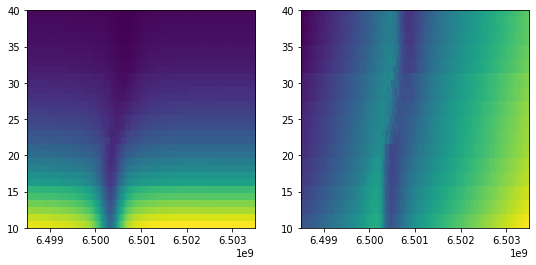

In [42]:
q_target, att = q1, np.linspace(15,40,26)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mr.S21vsPower, (q_target,measure,att,'com8',True), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

In [33]:
q1

qubit(q_name='q1', inst={'dc': 'dc03', 'z_awg': 'awg131', 'z_ch': [8], 'ex_awg': 'awg133', 'ex_ch': [3, 7], 'ex_lo': 'psg_ex1', 'com': 'com3'}, T_bias=[1.132, 0.3], specfunc=0.541605287359199*sqrt(Abs(cos(3.70594731677801*x + 2.92055965298964))) + 3.35424619070488, bias=0, zpulse=None, f_lo=array([6.535e+09]), delta=array([50000000.]), f_ex=array([5.161e+09]), delta_ex=array([1.1e+08]), alpha=269800000.0, power_ex=60, power_rabi=30, pi_len=16, T1=23016.178849233776, state=[{'q5': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q2': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': 0.78, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q10': {'offset

# singlespce

In [14]:
calimatrix = np.load(r'D:/QuLabData/2020/0624/crosstalk_cali/q1-q7_20200624171927.npz')['mat']
np.mat(calimatrix)

matrix([[ 1.        ,  0.        ,  0.02081242, -0.00556228, -0.03419392,
          0.0722012 ,  0.07923705,  0.        ,  0.        ,  0.        ],
        [-0.11087751,  1.        ,  0.00911005, -0.03760278, -0.02984445,
          0.07501739,  0.08099287,  0.        ,  0.        ,  0.        ],
        [-0.09237872,  0.        ,  1.        , -0.02808258, -0.03020463,
          0.05719553,  0.07826868,  0.        ,  0.        ,  0.        ],
        [-0.09966487,  0.        ,  0.08454681,  1.        , -0.03020463,
          0.05499408,  0.0763224 ,  0.        ,  0.        ,  0.        ],
        [-0.07804834,  0.        ,  0.07193357, -0.06137783,  1.        ,
          0.0501854 ,  0.07041253,  0.        ,  0.        ,  0.        ],
        [-0.08190848,  0.        ,  0.10309907, -0.06923761,  0.04200055,
          1.        ,  0.08362114,  0.        ,  0.        ,  0.        ],
        [-0.06118311,  0.        ,  0.07212722, -0.06237858,  0.03363237,
         -0.02547738,  1.       

In [138]:
q, bias = q1, -0.19
q.T_bias
q.T_bias[1]-q.T_bias[0]/2
x = sy.Symbol('x')
f_com = np.float(q.specfunc.evalf(subs={x:bias}))
print(round(f_com,3),q.T_bias,q.T_bias[1]-q.T_bias[0]/2)

3.753 [1.756, 0.06] -0.8180000000000001


In [61]:
q = q8
q.T_bias[1]-q.T_bias[0]/2

-0.9175

In [54]:
q_target = q3
# att_single, bias = q_target.power_ex, 0.15
await measure.attinst['com8'].set_att(30)
await mr.dcManage(measure,dcstate={'q3':-0.349},readstate=['q3'],calimatrix=None)

# zname, zch = [''.join((q_target.q_name,'_z'))], q_target.inst['z_ch']
# await cw.genwaveform(measure.awg[q_target.inst['z_awg']],zname,zch)
# await cw.zWave(measure.awg[q_target.inst['z_awg']],zname,during=20000e-9,volt=0,offset=0,shift=60000e-9)
# await measure.awg[q_target.inst['z_awg']].setValue('Offset',-0.0,ch=zch[0])
# await cw.couldRun(measure.awg[q_target.inst['z_awg']])
# await psg_ex1.setValue('Output','OFF')
# await psg_ex2.setValue('Output','OFF')
# await psg_ex3.setValue('Output','OFF')

Output()

[(3.8230499999999723, 0.0)]


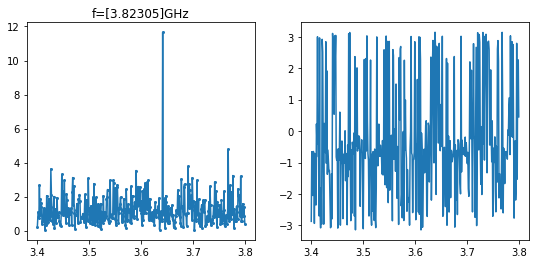

In [55]:
# tag, freq = q_target.q_name, np.arange(-200,201,1)*1e6+round(f_com,3)*1e9
freq = np.arange(3.4,3.8,0.001)*1e9
await psg_trans.setValue('Power',0)
# await measure.attinst['com9'].set_att(30)
# await cw.modulation_ex(q_target,measure)
# await mr.jpa_switch(measure,'ON')
job = Job(mr.singlespec, (q_target,measure,freq,True,measure.f_lo,True), tags=(['Nb']+measure.qubitToread), max=len(freq))
f_ss, s_ss = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
x,y,z,band= f_ss/1e9, s_ss,[],[]
for i in range(np.shape(s_ss)[1]):
    try:
        a,b,c,d,e = op.Lorentz_Fit().fitLorentz(x[:,i],np.abs(y[:,i]))
        z.append(a/(1.0+c*(x[:,i]-b)**2)+d)
        band.append((b,e))
    except:
        pass
z = np.array(z).T
f_rabi = np.array([x[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=2)
# axes[0].plot(x,z)
axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
print(band)
axes[1].plot(x,np.angle(y))
plt.show()

In [134]:
(3.992-3.859)*2

0.266

In [56]:
# q6 = q6._replace(f_ex=np.array([3.960e9]),delta_ex=np.array([220e6]),alpha=268e6,state=[state,measure.delta,measure.base,measure.readlen])
q3 = q3._replace(f_ex=np.array([3.641e9]),delta_ex=np.array([110e6]),state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

q8      q1      q7      q2     jpa      q6      q4      q5  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        0       0       0       0       0       0       0       0   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

             q3      q9     q10        psg_lo       psg_ex1    psg_trans  \
error        +0      +0      +0             0             0            0   
freq        NaN     NaN     NaN   6.583025GHz   5.271000GHz  3.799000GHz   
load     high Z  high Z  high Z           NaN           NaN          NaN   
mform       NaN     NaN     NaN           EXT           EXT          EXT   
moutput     NaN     NaN     NaN             0             0            1   
offset   -0.349       0       0           NaN           NaN          NaN   
output      NaN     NaN     NaN             1             0            0   
power       NaN     NaN     NaN  18.000000dBm  15.000000dBm  0.000000dBm   

            psg_pump  
error              0  
freq     2.000000GHz  
load             NaN  
mform         EXT2\r  
moutput          0\r  
offset           NaN  
output           0\r  
power    0.000000dBm

In [107]:
q6

qubit(q_name='q6', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': [6], 'ex_awg': 'awg134', 'ex_ch': [4, 8], 'ex_lo': 'psg_ex1', 'com': 'com3'}, T_bias=[1.759, 0.3], specfunc=2.50097887434493*sqrt(Abs(cos(2.31494361107522*x + 6.4569418462785))) + 1.49302240016532, bias=-0.9, zpulse=None, f_lo=array([6.6e+09]), delta=array([50000000.]), f_ex=array([5.3324e+09]), delta_ex=array([1.1e+08]), alpha=268000000.0, power_ex=60, power_rabi=36, pi_len=39, T1=None, state=[{'q5': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.592, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q2': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q10': {'offset': 0.0, 'load

In [40]:
q10 = q10._replace(f_lo=np.array([6.633])*1e9,delta_ex=np.array([110e6]))

## 单条谱扫电压

Output()

<IPython.core.display.Javascript object>


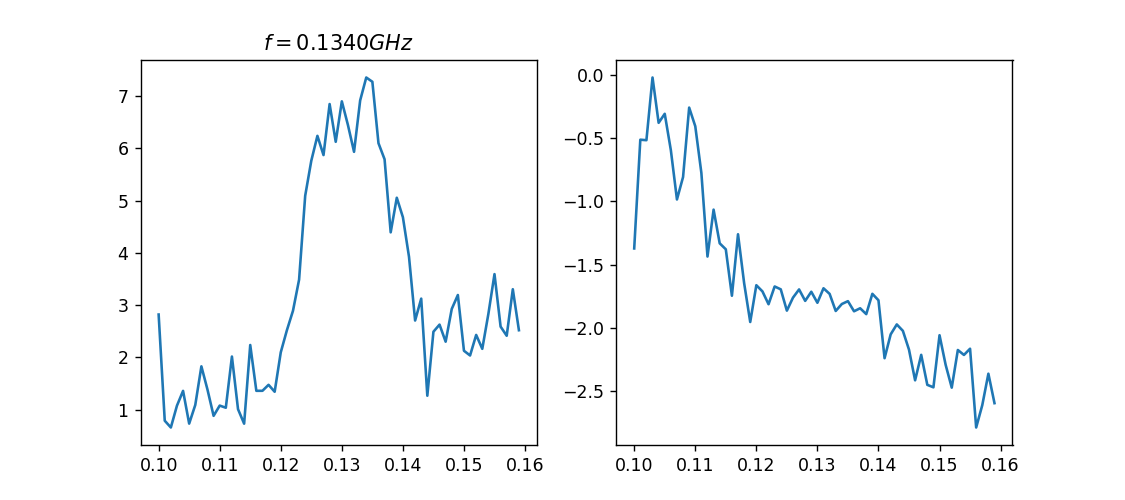

In [135]:
tag, ftarget, biaslist = q_target.q_name, 4.0596e9, np.arange(-0.03,0.03,0.001) + (0.13)

# await psg_trans.setValue('Power',13)
# mr.Att_Setup(measure,'com8').Att(28)
# await cw.modulation_ex(q_target,measure)
# # await psg_ex1.setValue('Moutput','OFF')
# await mr.jpa_switch(measure,'ON')
job = Job(mr.specbias, (q_target,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(v_rabi[0]))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# Rabi

In [330]:
mr.Att_Setup(measure,'com4').Att(0)

com4 open...
last ATT 30.0
now ATT 00.0


Output()

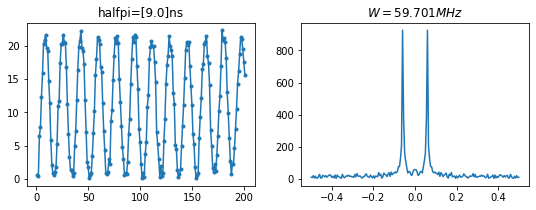

In [58]:
q_target = q3
t_rabi = np.linspace(1,201,201)
att_single = 30
tag = q_target.q_name
# await measure.attinst[q_target.inst['com']].set_att(att_single)
# await psg_ex1.setValue('Power',3)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
# await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
for i in range(1):
#     await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)),awg=1)
    job = Job(mr.rabi, (q_target,measure,t_rabi,False,1,1), tags=[tag], max=500,avg=True)
    t_r, s_r = await job.done()
#     state = await mr.QueryInst(measure)
    index = np.abs(s_r).argmax(axis=0)
    t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
    fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
    t_op = []
    for i in range(np.shape(s_r)[1]):
        x, y = t_r[:,i], np.abs(s_r[:,i])
        t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
        w,yt,amp = op.RowToRipe().fourier(x,y)
        axes[0].plot(x,y,'-o',markersize=3)
        axes[0].set_title(f'halfpi={t_op}ns')
        axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
        axes[1].set_title('$W=%.3fMHz$'%(w*1000))
    plt.show()

In [59]:
q3 = q3._replace(pi_len=8.58,power_rabi=att_single)
# pd.DataFrame(state)

In [46]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': [3], 'ex_awg': 'awg133', 'ex_ch': [3, 7], 'ex_lo': 'psg_ex1', 'com': 'com6'}, T_bias=[2.078, -0.246], specfunc=2.46792827275642*sqrt(Abs(cos(2.35499592062898*x + 6.11919722835418))) + 1.52013910373761, bias=0.37, zpulse=None, f_lo=array([6.478e+09]), delta=array([50000000.]), f_ex=array([3.9463e+09]), delta_ex=array([1.1e+08]), alpha=266000000.0, power_ex=60, power_rabi=20, pi_len=23, T1=23016.178849233776, state=[{'q5': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': -0.05, 'load': 'high Z', 'error': '+0'}, 'q2': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q9': {'

# rabi测试

Output()

<IPython.core.display.Javascript object>


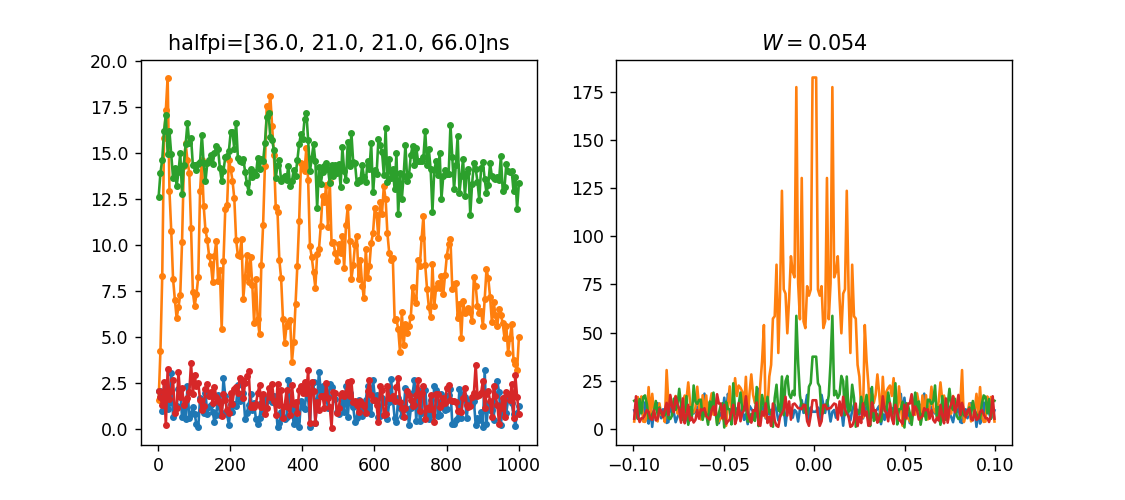

In [1460]:
exstate = {'q5':35}
# mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex3.setValue('Power',10)
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.rabitest, (measure,t_rabi,True,1,1,exstate), tags=[tag], max=500,avg=True)
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
t_op = []
for i in range(np.shape(s_r)[1]):
    x, y = t_r[:,i], np.abs(s_r[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    w, yt, amp = op.RowToRipe().fourier(x,y)
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].set_title(f'halfpi={t_op}ns')
    axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
    axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [1113]:
q1 = q1._replace(pi_len=13.5,state=[state,measure.delta,measure.base,measure.readlen])
q10 = q10._replace(pi_len=23.5,state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

q2      q6     jpa      q1      q3      q8      q7     q10  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset       -1       0  -0.019    0.17       0       0       0    0.15   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

             q4      q5      q9       psg_lo      psg_ex1       psg_ex2  \
error        +0      +0      +0            0            0             0   
freq        NaN     NaN     NaN  6.678700GHz  3.963740GHz   3.963740GHz   
load     high Z  high Z  high Z          NaN          NaN           NaN   
mform       NaN     NaN     NaN          EXT          EXT           EXT   
moutput     NaN     NaN     NaN            0            0             0   
offset        0       0      -1          NaN          NaN           NaN   
output      NaN     NaN     NaN            1            1             1   
power       NaN     NaN     NaN  5.000000dBm  6.000000dBm  10.000000dBm   

              psg_ex3      psg_pump    psg_trans  
error               0            +0            0  
freq      4.012900GHz  12.602000GHz  3.999000GHz  
load              NaN           NaN          NaN  
mform             EXT           INT          EXT  
moutput             0             0            1  
offset            NaN           NaN          NaN  
output              0             1            0  
power    10.000000dBm  -2.730000dBm  3.000000dBm

In [1116]:
measure.qubits = {i.q_name:i for i in [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]}

# pi脉冲振幅

In [1147]:
q_target = q10
t_rabi = np.linspace(1,501,201)
att_single = 35

com9 open...
last ATT 35.0
now ATT 35.0


Output()

<IPython.core.display.Javascript object>


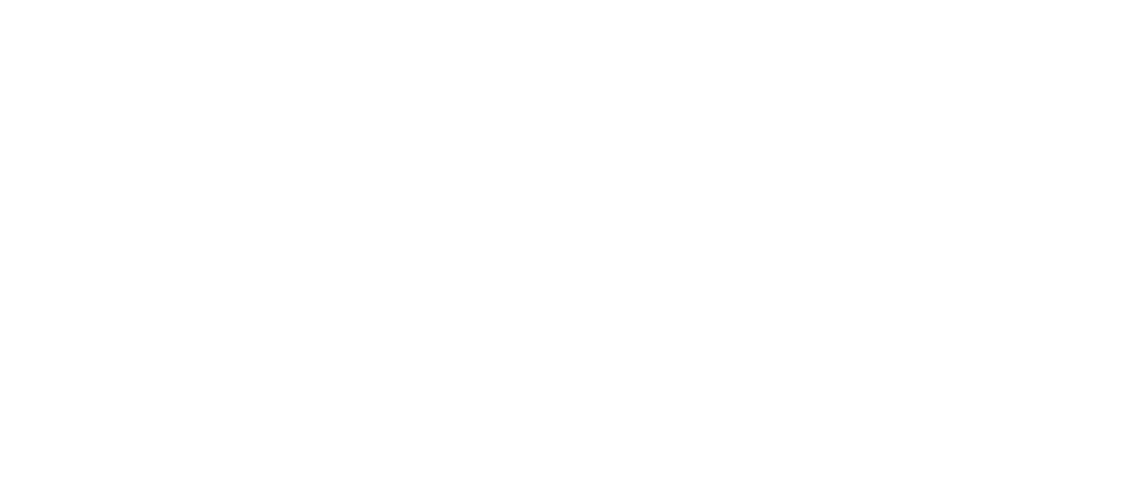

In [1149]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseAmp, (q_target,measure,t_rabi), tags=[tag], max=9)
amp_pi, t_amp, s_amp = await job.done()
state = await mr.QueryInst(measure)
x, y , s = amp_pi[:,0], t_amp[0][:,0], s_amp[:,:,0]
wlist = [((op.RowToRipe().fourier(y,np.abs(i)))[0]) for i in s]
t_op = op.RowToRipe().firstMax(y,np.abs(s[-1]),num=0,peakpercent=0.7)
a = np.polyfit(x,wlist,1)
z = np.poly1d(a)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].set_yticks(x)
axes[1].plot(x,wlist,'.')
axes[1].plot(x,z(x))
axes[1].set_title(f'$grad={a[0]}$')
plt.show()

# rabi_waveform

Output()

<IPython.core.display.Javascript object>


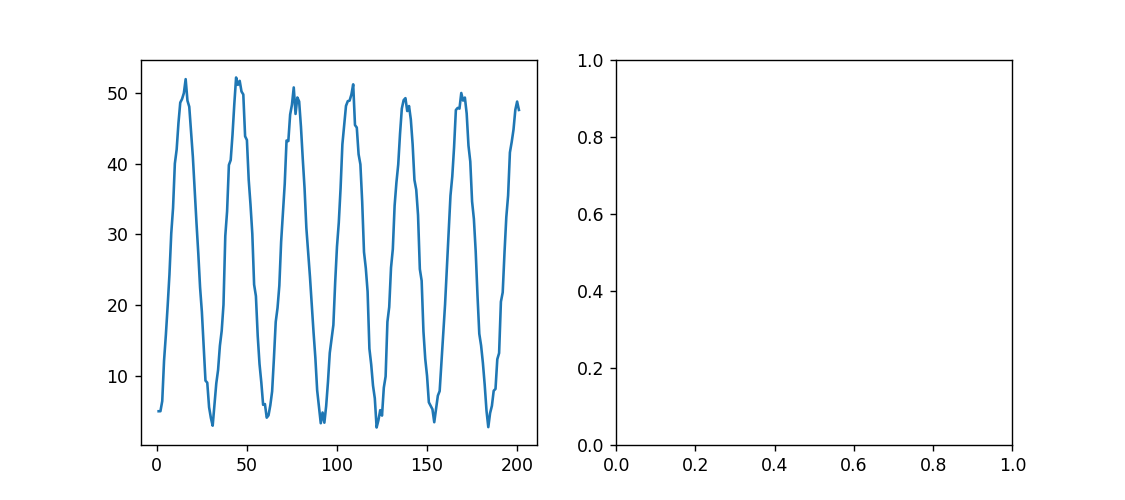

In [194]:
t_rabi, q_target = np.linspace(1,201,201), q1
att_single = 40
await measure.attinst[q_target.inst['com']].set_att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.Rabi_waveform, (q_target,measure,t_rabi,1), tags=[q_target.q_name], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

# rabiPower

Output()

<IPython.core.display.Javascript object>


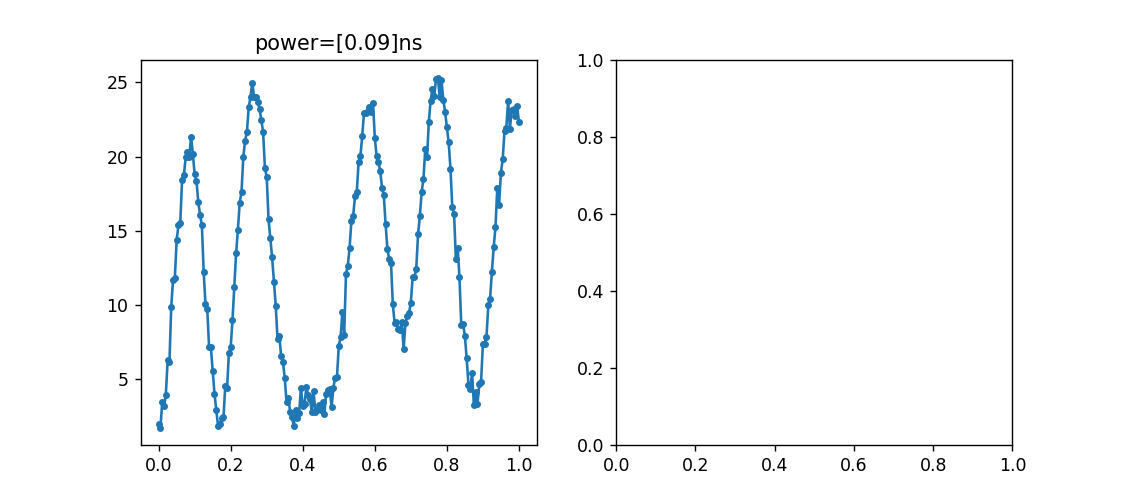

In [112]:
amplitude, q_target = np.linspace(0,1,201), q1
att_single = 13
# mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPower, (q_target,measure,20,False,amplitude,1), tags=[tag], max=500,avg=True)
t_rp, s_rp = await job.done()
state = await mr.QueryInst(measure)
t_op = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(np.shape(s_rp)[1]):
    x, y = t_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    sample = (np.max(x) - np.min(x))/(len(x) - 1)
    yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
    amp = np.fft.fftshift(np.fft.fft(y))

    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].set_title(f'power={t_op}ns')
#     axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
#     axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [ ]:
q3 = q3._replace(pi_len=20,power_rabi=t_op,state=[state,measure.delta,measure.base,measure.readlen])

# Readout point

Output()

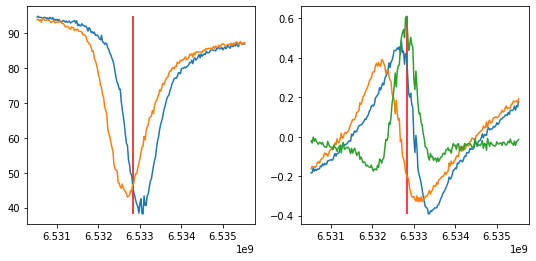

In [65]:
q_target = q3
# await measure.attinst['com8'].set_att(30)
await measure.attinst[q_target.inst['com']].set_att(q_target.power_rabi)
# await mr.jpa_switch(measure,state='ON')
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.readOp, (q_target,measure,True,measure.f_lo), tags=[q_target.q_name], max=2)
st, f_op, s_op= await job.done()
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mr.resn(np.array(f_lo))
axes[0].set_title(f'fread={f_lo-20e6}')
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
await psg['psg_lo'].setValue('Frequency',f_lo)

In [97]:
%matplotlib notebook

In [99]:
6.63148-6.62905

0.002429999999999488

<IPython.core.display.Javascript object>


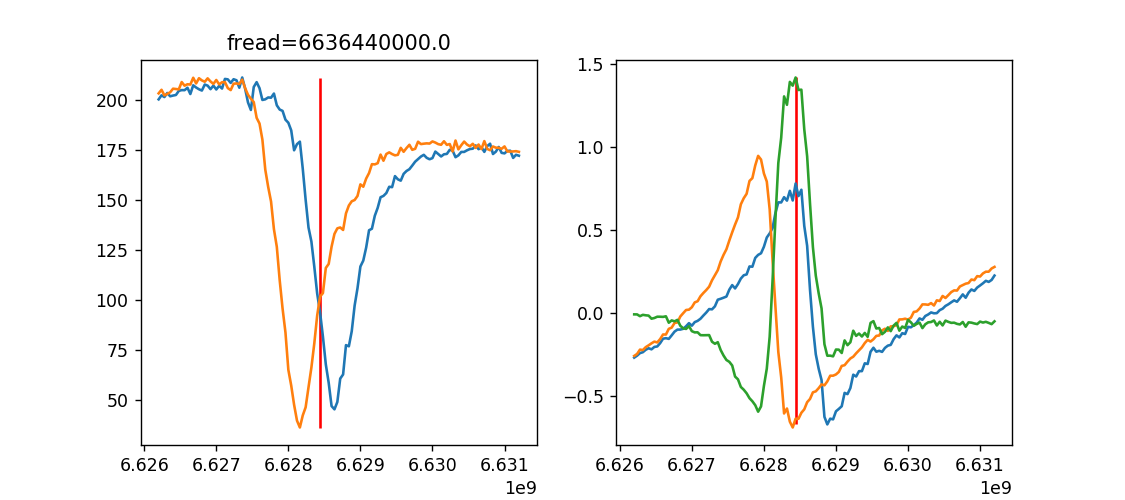

In [546]:
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mr.resn(np.array(f_lo))
axes[0].set_title(f'fread={f_lo-20e6}')
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
await psg['psg_lo'].setValue('Frequency',f_lo)

In [357]:
q6 = q6._replace(state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

q2      q6     jpa      q1      q3      q8      q7     q10  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        0   -0.15    1.75       0    -1.6       0    -1.2       0   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

             q4      q5      q9       psg_lo      psg_ex1       psg_ex2  \
error        +0      +0      +0            0            0             0   
freq        NaN     NaN     NaN  6.653100GHz  4.114300GHz   4.088000GHz   
load     high Z  high Z  high Z          NaN          NaN           NaN   
mform       NaN     NaN     NaN          EXT          EXT           EXT   
moutput     NaN     NaN     NaN            0            0             0   
offset       -1      -1       0          NaN          NaN           NaN   
output      NaN     NaN     NaN            1            1             0   
power       NaN     NaN     NaN  5.000000dBm  3.000000dBm  10.000000dBm   

              psg_ex3      psg_pump     psg_trans  
error               0            +0             0  
freq      7.180000GHz  13.162000GHz   4.099000GHz  
load              NaN           NaN           NaN  
mform             EXT           INT           EXT  
moutput             0             0             1  
offset            NaN           NaN           NaN  
output              0             1             0  
power    10.000000dBm  23.160000dBm  13.000000dBm

# 读出点测试

Output()

<IPython.core.display.Javascript object>


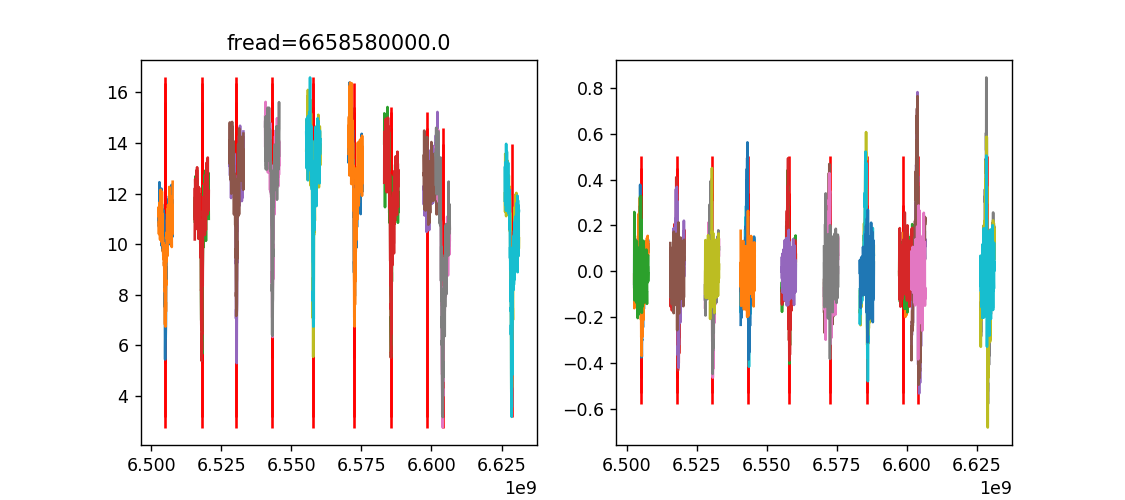

In [31]:
exstate = {'q1':35,'q10':35}
await mr.jpa_switch(measure,state='ON')
job = Job(mr.readOptest, (measure,True,measure.f_lo,exstate), tags=exstate.keys(), max=2)
st, f_op, s_op = await job.done()
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mr.resn(np.array(f_lo))
axes[0].set_title(f'fread={f_lo-50e6}')
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
await psg['psg_lo'].setValue('Frequency',f_lo)

# 优化读出长度

Output()

<IPython.core.display.Javascript object>


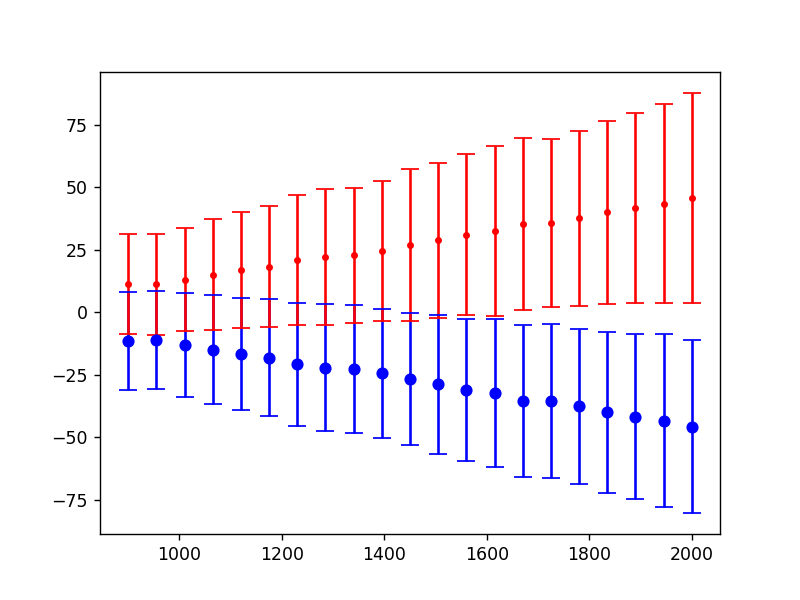

In [308]:
# await measure.psg['psg_lo'].setValue('Power',13)
# mr.Att_Setup(measure,'com7').Att(13)
job = Job(mr.readWavelen, (q_target,measure), tags=[tag], max=21)
wl, s_wl = await job.done()
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

In [251]:
4*np.sqrt(np.log(2))

3.3302184446307908

In [ ]:
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

# 临界线

In [515]:
measure.readlen = 2000

Output()

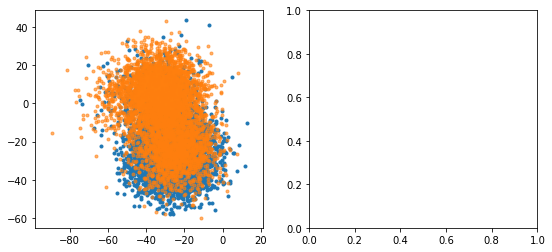

In [67]:
q_target = q3
await measure.attinst['com8'].set_att(32)
job = Job(mr.threshHold, (q_target,measure,True), tags=[q_target.q_name], max=2)
st, s_st, s_st_Q = await job.done()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


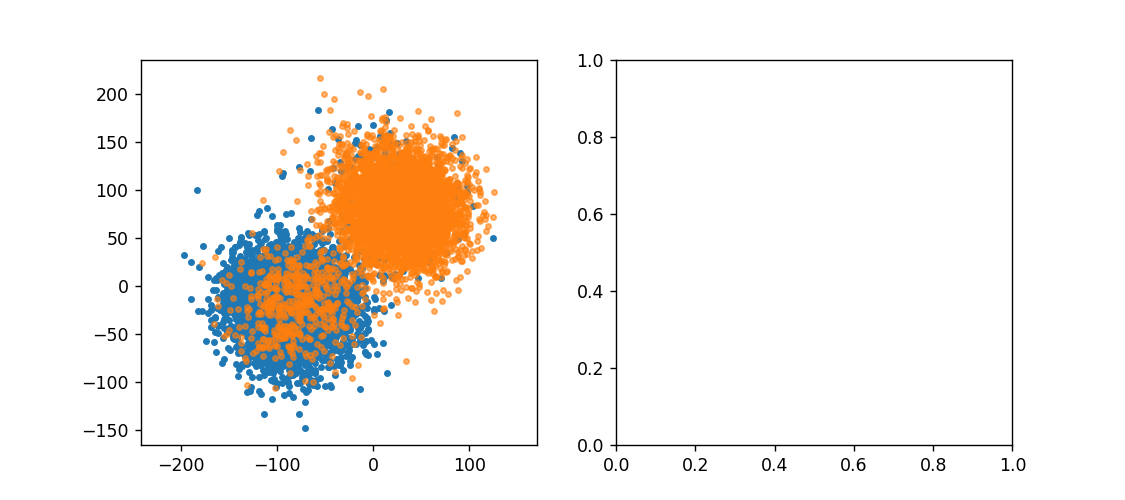

In [561]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


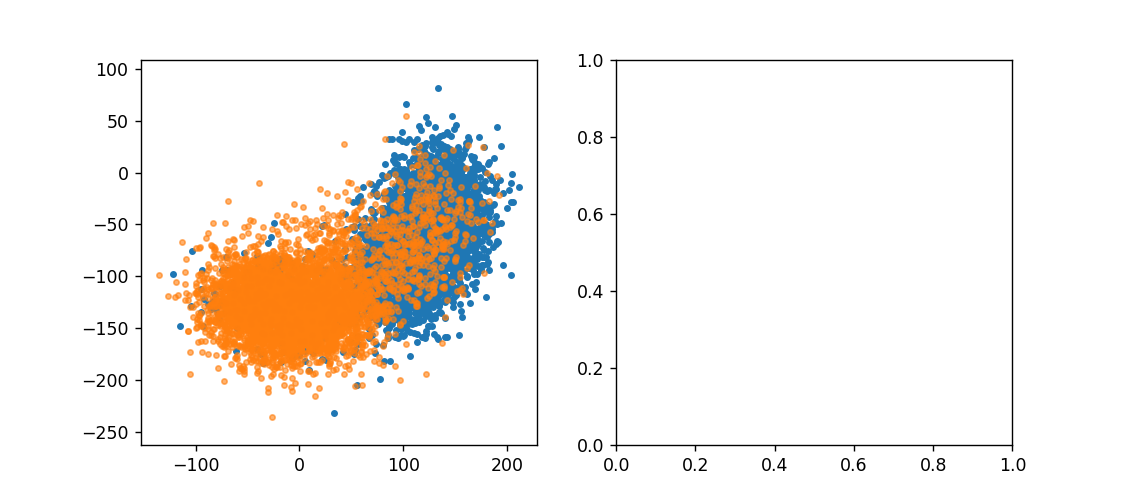

In [227]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

## 测试

com7 open...
last ATT 13.5
now ATT 11.0


Output()

<IPython.core.display.Javascript object>


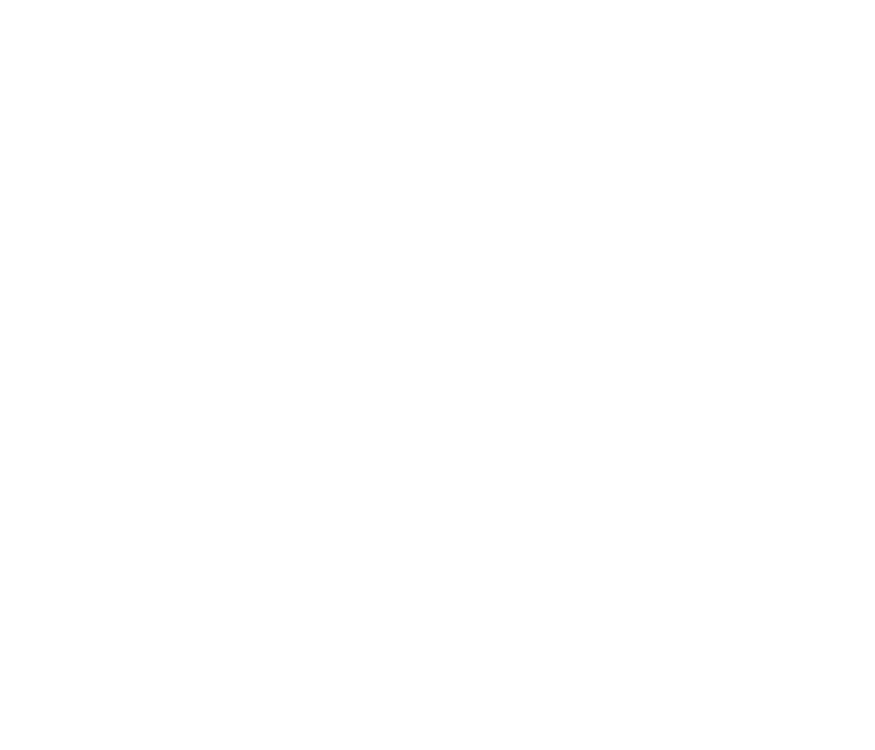

In [1134]:
exstate = {'q1':35,'q10':35}
# await measure.psg['psg_lo'].setValue('Power',13)
mr.Att_Setup(measure,'com7').Att(11)
job = Job(mr.threshHoldtest, (measure,True,exstate), tags=exstate.keys(), max=2)
st, s_st = await job.done()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


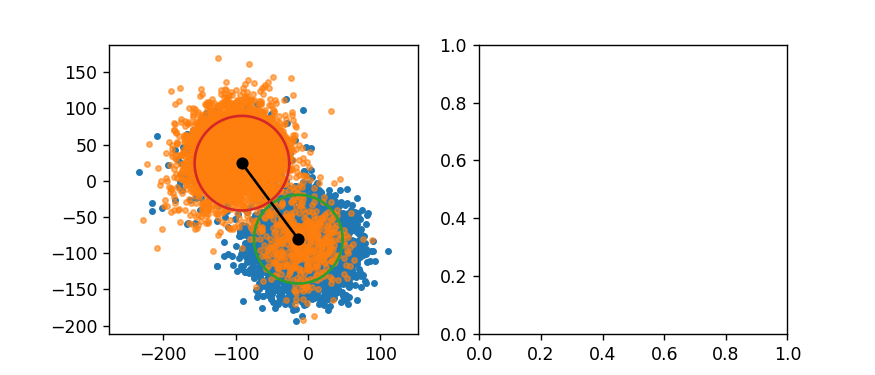

In [565]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    offmean, onmean = np.mean(x), np.mean(y)
    offstd, onstd = np.std(x), np.std(y)
    theta = np.arange(0, 2*np.pi, 0.01)
    roff = np.real(offmean) + offstd * np.cos(theta)
    ioff = np.imag(offmean) + offstd * np.sin(theta)
    ron = np.real(onmean) + onstd * np.cos(theta)
    ion = np.imag(onmean) + onstd * np.sin(theta)
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
    ax.plot(roff,ioff)
    ax.plot([np.real(offmean),np.real(onmean)],[np.imag(offmean),np.imag(onmean)],'k-o')
    ax.plot(ron,ion)
plt.show()

<IPython.core.display.Javascript object>


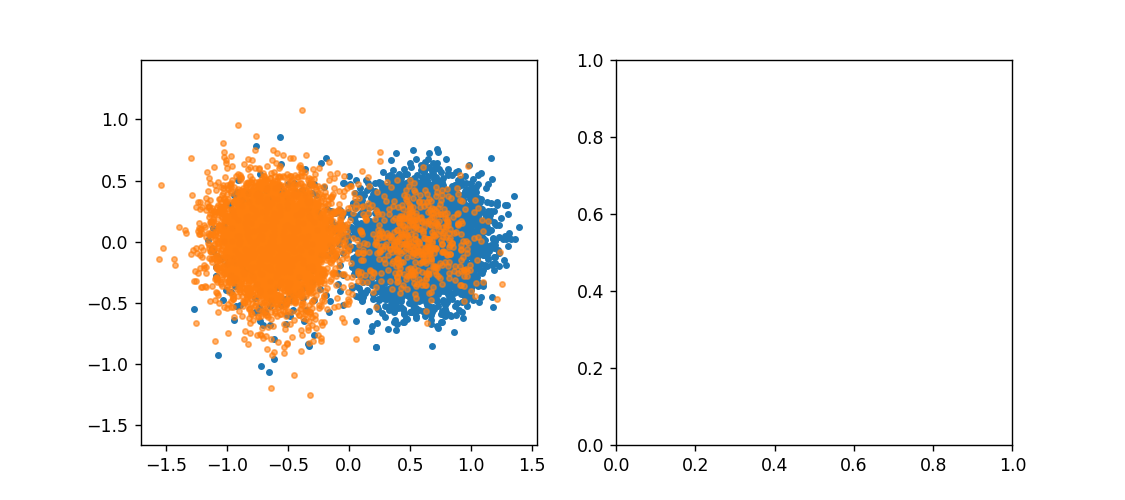

In [566]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
    s_off, s_on = (x-add)/diff, (y-add)/diff
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

In [252]:
measure.readlen

1200

In [1606]:
measure.qubitToread 

['q1']

0.5983979430379747


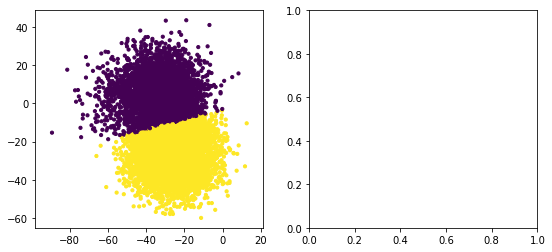

In [68]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
predict = {}
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict[measure.qubitToread[i]] = kmeans.predict
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

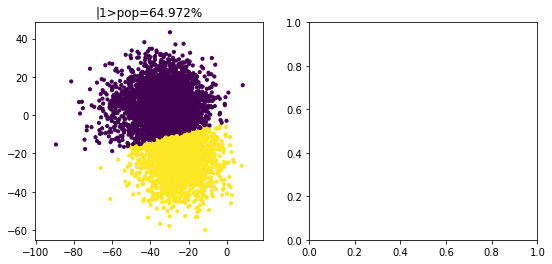

In [69]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
onwhich, offwhich = [], []
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent1 = list(y).count(which)/len(y)
    onwhich.append(which if percent1 > 0.5 else 1-which)
    offwhich.append(1-which if percent1 > 0.5 else which)
    percent = list(y).count(onwhich[i])/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

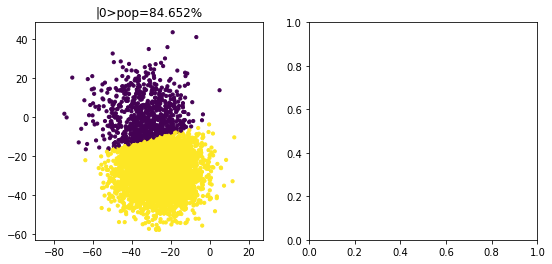

In [70]:
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_off, measure.offwhich[i]
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent = list(y).count(which)/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()

# rabiPopulation

com13 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


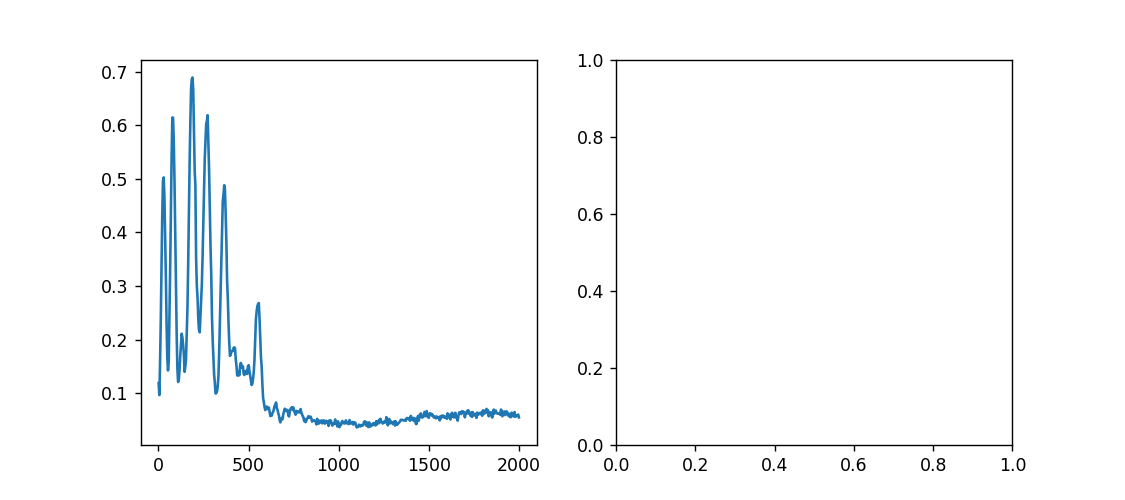

In [98]:
t_rabi, q_target, which = np.linspace(1,2001,501), q3, 1
att_single = 20
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex2.setValue('Output','OFF')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPop, (q_target,measure,t_rabi,which), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

0.10700158227848101


<IPython.core.display.Javascript object>


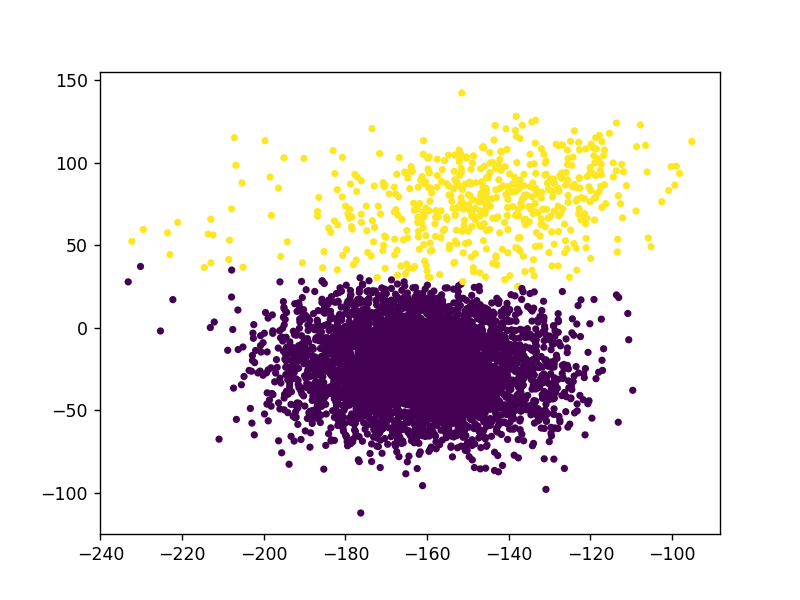

In [148]:
ss, which = pop[4,:,0], 1
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# 优化读出功率

Output()

<IPython.core.display.Javascript object>


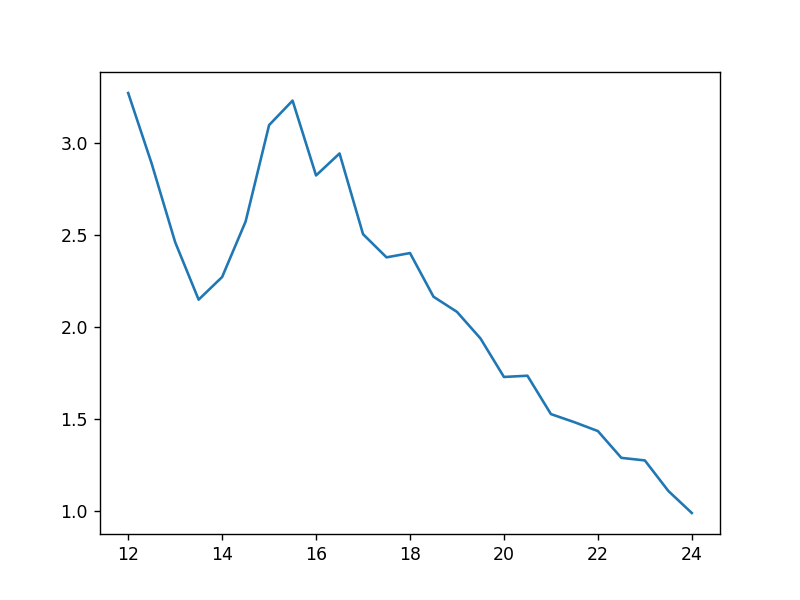

In [77]:
com, att = 'com7', np.linspace(12,24,25)
job = Job(mr.readpowerOpt, (q_target,measure,com,att), tags=[tag], max=len(att))
# attopt, popoff, popon = await job.done()
# plt.figure()
# plt.plot(attopt,popoff)
# plt.plot(attopt,popon)
# plt.show()
attopt, snr = await job.done()
plt.figure()
plt.plot(attopt,snr)
plt.show()

# pi脉冲优化

## sequance

Output()

<IPython.core.display.Javascript object>


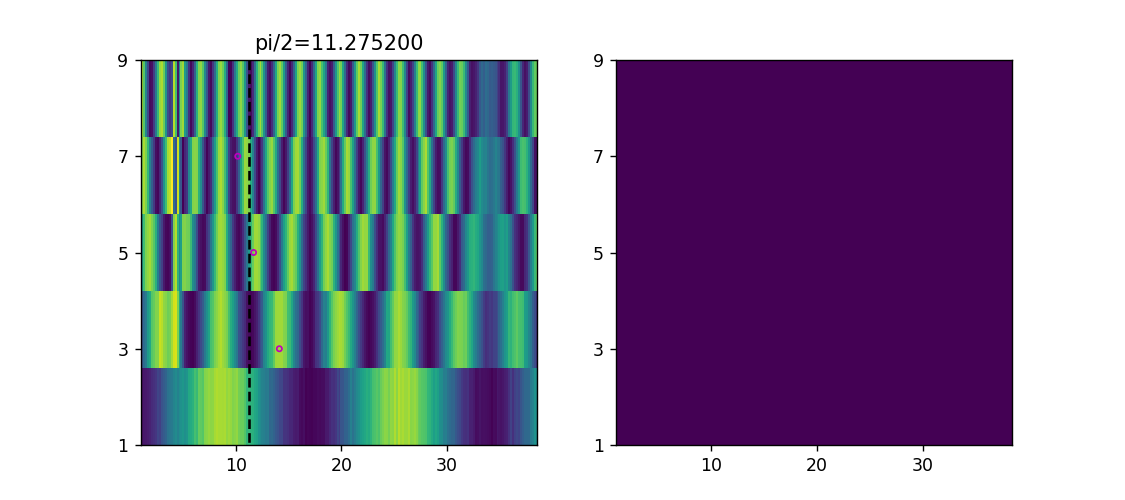

In [168]:
q_target, nwave, wavlen = q6, 5, len(t_rabi)
tag = q_target.q_name
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt, (q_target,measure,nwave,wavlen), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=12,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

In [169]:
q6 = q6._replace(pi_len=8.46,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

## waveform

Output()

<IPython.core.display.Javascript object>


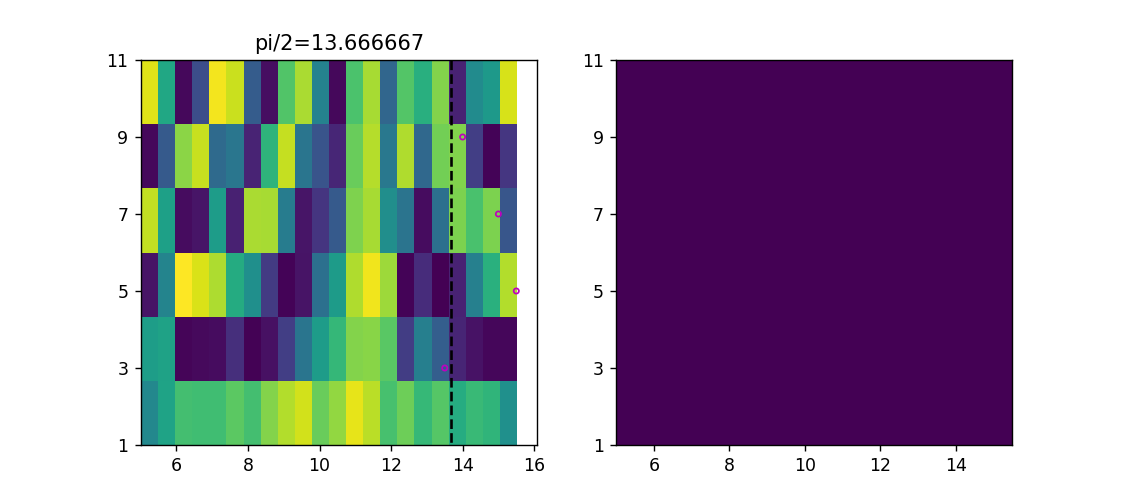

In [100]:
q_target, nwave, wavlen = q3, 6, len(t_rabi)
tag = q_target.q_name
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt_waveform, (q_target,measure,nwave), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=16,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

# pipulseDetune

Output()

Output()

Output()

<IPython.core.display.Javascript object>


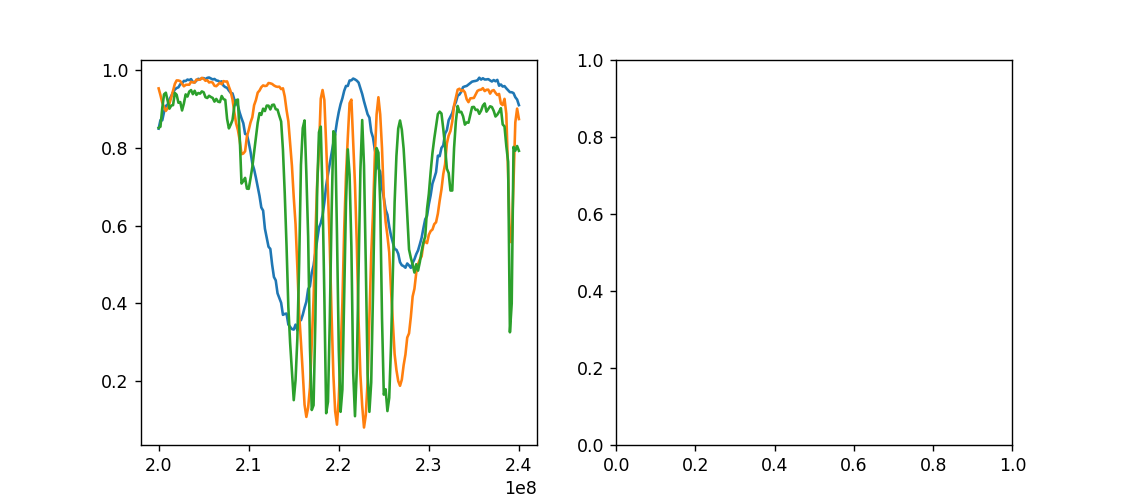

In [156]:
q_target, which = q6, measure.offwhich[0]
alpharatiodelta = -1/ q_target.alpha / (2*np.pi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
popn = []
for i in (1,5,10):
    job = Job(mr.detuneOpt, (q_target,measure,which,alpharatiodelta,i), tags=[q_target.q_name], max=201)
    f_op, pop = await job.done()
    popn.append(pop)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(len(popn)):
    x, y = f_op[:,0], popn[i][:,0]
    axes[0].plot(x,np.abs(y))
plt.show()

In [ ]:
x, y1, y2 = f_op[:,0], popn[0][:,0], popn[1][:,0]
# f01 = op.RowToRipe().firstMax(x,y,num=(q_target.f_ex+q_target.delta_ex)[0],peakpercent=0.7)
index = np.argmin(np.abs(y1-y2))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y1))
axes[0].plot(x,np.abs(y2))
axes[0].set_title('Delta_lo=%.4f MHz'%((x[index])/1e6))
plt.show()

# DragcoefHD

Output()

<IPython.core.display.Javascript object>


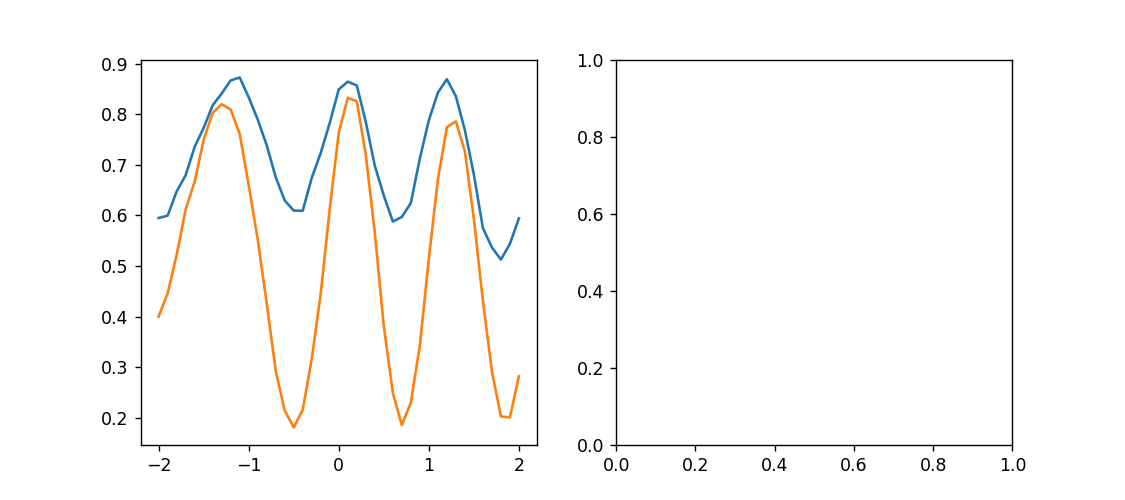

In [568]:
q_target, which, axis = q10, measure.onwhich[0], [['Xnhalf','Xhalf'],['Ynhalf','Yhalf']]
alpha = q_target.alpha * (2*np.pi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.dragcoefHD, (q_target,measure,which,alpha,axis,3), tags=[q_target.q_name], max=82)
f_op, s_op = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(f_op)[0]//2
f1, f2, s1, s2 = f_op[:l,0], f_op[l:,0], np.abs(s_op[:l,0]), np.abs(s_op[l:,0])
axes[0].plot(f1,np.abs(s1))
axes[0].plot(f2,np.abs(s2))
plt.show()

# IQ-Mixer优化相位

Output()

<IPython.core.display.Javascript object>


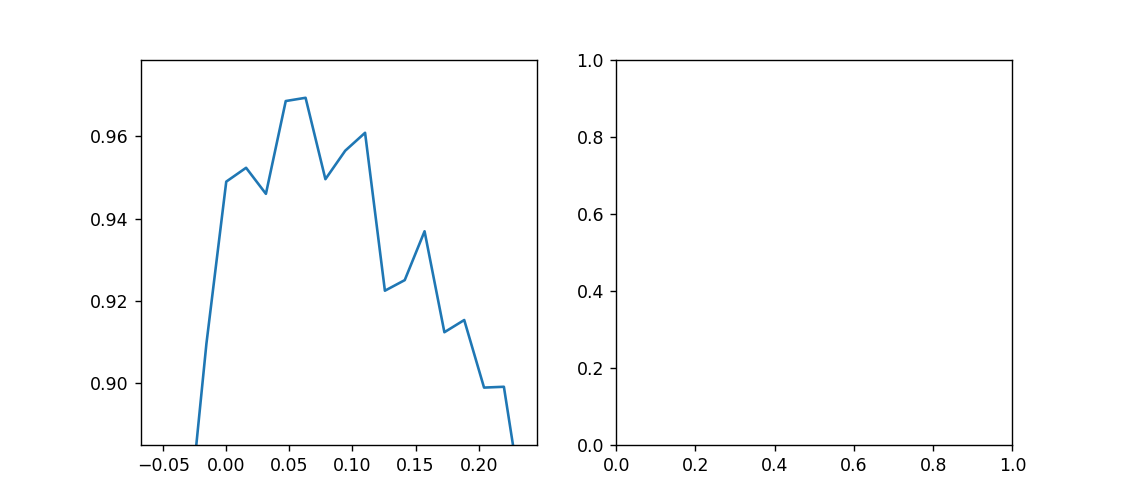

In [106]:
q_target, which = q6, measure.offwhich[0]
alpha = q_target.alpha
job = Job(mr.IQphaseOpt, (q_target,measure,which,5,alpha), tags=[q_target.q_name], max=201)
phase_op, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(phase_op[:,0],np.abs(pop[:,0]))
plt.show()

In [84]:
await psg_ex1.setValue('Frequency',4.0576e9)

In [1232]:
qubit = q5
name, awg_target = [qubit.q_name+'_I', qubit.q_name+'_Q'], measure.awg[qubit.inst['ex_awg']]
await cw.genwaveform(measure,awg_target,name,qubit.inst['ex_ch'])
await cw.modulation_read(measure,measure.delta,tdelay=measure.readlen)
await measure.psg[qubit.inst['ex_lo']].setValue('Frequency',(qubit.f_ex)[0])
await measure.psg['psg_lo'].setValue('Output','ON')
ch1, ch2 = qubit.inst['ex_ch']
    
async def awgoffset(offset1,offset2):
    await awg_target.stop()
    await awg_target.setValue('Offset',offset1,ch=ch1)
    await awg_target.setValue('Offset',offset2,ch=ch2)
    await cw.couldRun(awg_target)
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','ON')
    ch_A, ch_B = await measure.ats.getIQ()
    Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
    theta0 = np.angle(Am) - np.angle(Bm)
    Bm *= np.exp(1j*theta0)
    s = Am + Bm
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','OFF')
    return np.abs(s - measure.base)

In [1233]:
# await cw.ats_setup(ats18,np.array([50e6]),l=1500,repeats=500)
opt.optimize(awgoffset,[-0.1,-0.5],[0.01,0.01],[3,3],high=[2,2],low=[-2,-2],print_info=True,algorithm='basinhopping')

.o
[-0.1 -0.5] [73.37549395]   .o
[-0.105 -0.5  ] [68.13018893]   ......................o
[-0.105 -0.501] [67.74947406]   .........................................................................o
[ 0.329 -0.831] [67.32442623]   ......................................................................................................................................................................................................................................................................................................o
[-0.115 -1.392] [66.53918799]   ...........................................................................................................................................................................................................................................................................................................................................................................................................................................................

                        fun: 53.40129378817715
 lowest_optimization_result:  final_simplex: (array([[-1.32537874, -0.79252065],
       [-1.32535275, -0.79256951],
       [-1.32529417, -0.79259195]]), array([53.40129379, 53.40129379, 53.40129379]))
           fun: 53.40129378817715
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 19
        status: 0
       success: True
             x: array([-1.32537874, -0.79252065])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1518
                        nit: 30
                          x: array([-1.325, -0.793])

# AllXY dragdetune

Output()

<IPython.core.display.Javascript object>


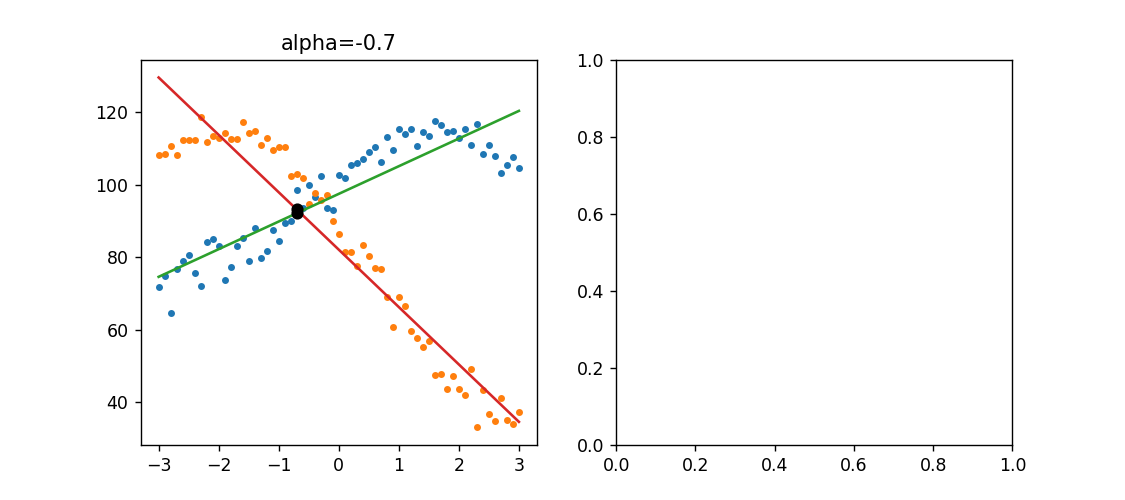

In [466]:
q_target, which = q10, 0
alpha = q_target.alpha*2*np.pi

await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.AllXYdragdetune, (q_target,measure,which,alpha), tags=[q_target.q_name], max=122)
fall, sall = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(fall)[0]//2
f1, f2, s1, s2 = fall[:l,0], fall[l:,0], np.abs(sall[:l,0]), np.abs(sall[l:,0])
z1 = np.poly1d(np.polyfit(f1,s1,1))(f1)
z2 = np.poly1d(np.polyfit(f2,s2,1))(f2)
index = np.argmin(np.abs(z1-z2))
axes[0].plot(np.array([f1,f2]).T,np.array([s1,s2]).T,'.')
axes[0].plot(np.array([f1,f2]).T,np.array([z1,z2]).T)
# axes[0].plot(fall[l:,:],np.abs(sall[l:,:]))
axes[0].plot([f1[index],f2[index]],[z1[index],z2[index]],'ko')
axes[0].set_title(f'alpha={round(f1[index],3)}')
plt.show()

# AC-Stark

Output()

<IPython.core.display.Javascript object>


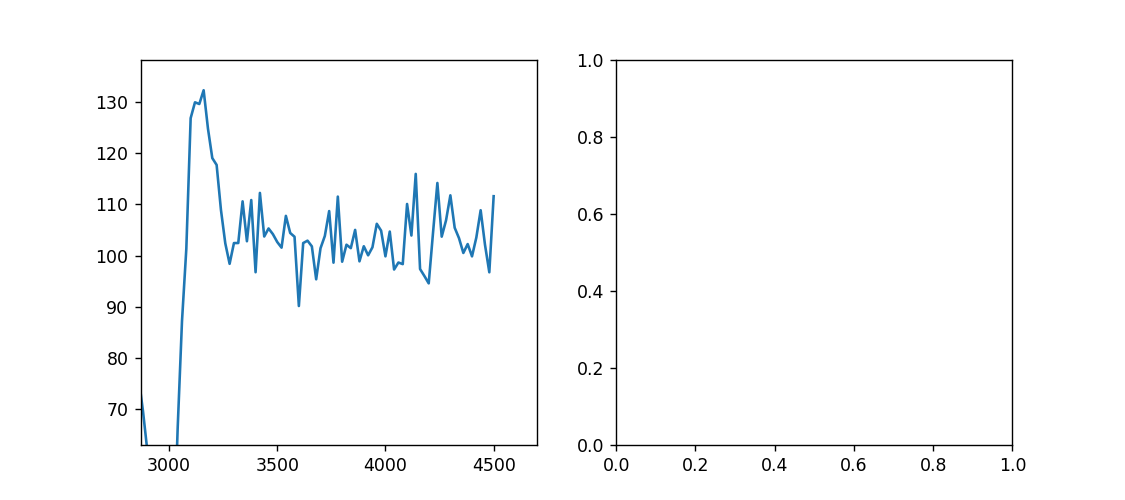

In [255]:
t_ac, q_target = np.linspace(500,4500,201), q3
job = Job(mr.singleacStark, (q_target,measure,t_ac,220e6), tags=[q_target.q_name], max=500,avg=True)
t_AC, s_AC = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_AC,np.abs(s_AC))
# axes[1].plot(t_AC,np.angle(s_AC.mean(axis=0)))
plt.show()

## 2D

In [448]:
t_ac, q_target = np.linspace(2000,4000,101), q6
job = Job(mr.acStark, (q_target,measure,t_ac), tags=[q_target.q_name], max=101)
t_AC, f_AC, s_AC = await job.done()

Output()

In [256]:
3500-3277

223

In [415]:
q5 = q5._replace(timing={'read>xy':(0),'z>xy':0})

In [17]:
q = q._replace(timing={'read>xy':(-200),'z>xy':0})

## ZPulse与激励时序

In [441]:
t_z, q_target = np.linspace(600,1500,101), q6
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.zPulse_freq, (q_target,measure,t_z), tags=[q_target.q_name], max=101)
t_z, f_z, s_z = await job.done()
# x, y , s = f_z[:,0], t_z[0][:,0], s_z[:,:,0]
# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
# axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
# plt.show()

Output()

IndexError: too many indices for array

In [55]:
t_z, q_target = np.linspace(450,805,101), q6
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.zPulse_offset, (q_target,measure,t_z), tags=[q_target.q_name], max=25)
offset, t_z, s_z = await job.done()

Output()

In [477]:
np.array((1,))

array([1])

## 单条

Output()

<IPython.core.display.Javascript object>


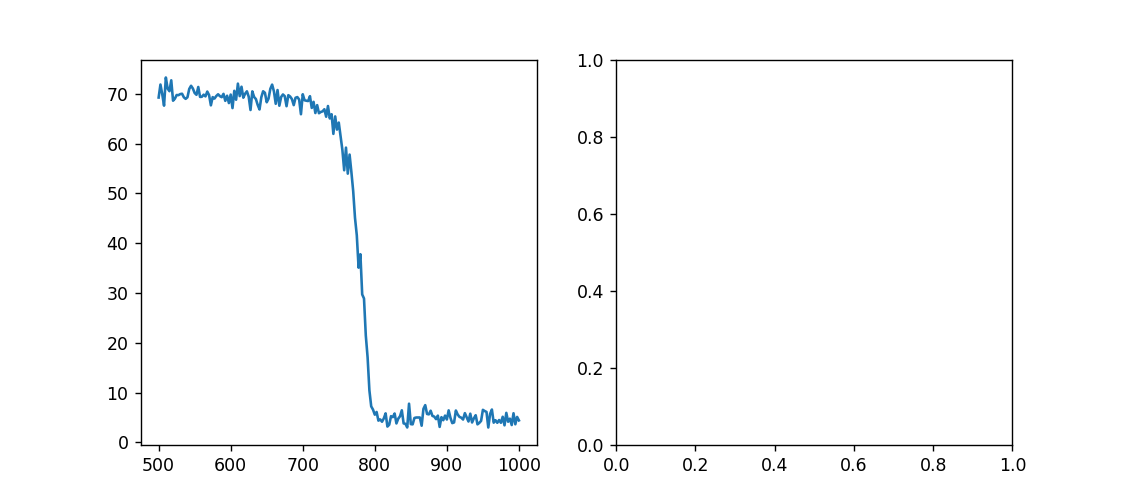

In [144]:
t_z, q_target = np.linspace(500,1000,201), q6
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.singleZpulse, (q_target,measure,t_z,220e6,True), tags=[tag], max=500,avg=True)
t_z, s_z = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_z[:,0],np.abs(s_z[:,0]))
plt.show()

<IPython.core.display.Javascript object>


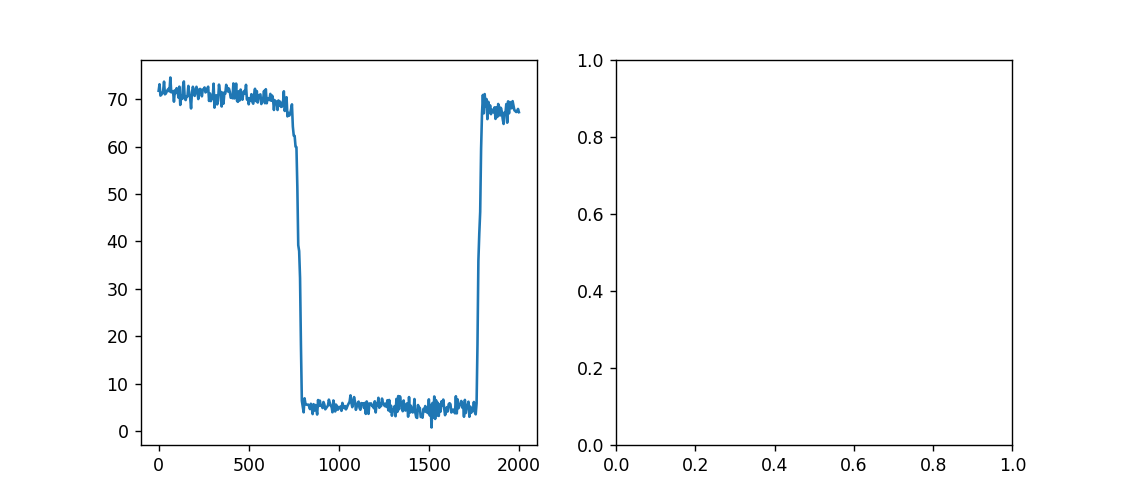

In [143]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_z[:,0],np.abs(s_z[:,0]))
plt.show()

In [45]:
x,y=t_z[50:100,0],np.abs(s_z[50:100,0])
a, b, c, d, e = op.TwoExp_Fit().fitTwoexp(x,y)
z = a*np.exp(b*x) + c*np.exp(d*x) + e 
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].plot(x,z)
plt.show()

(2185.076969925007, -0.00025612251383307224, 437.01539398500137, -5.122450276661445e-05, 15.389112254013714)


# ramseyZpulse

Output()

<IPython.core.display.Javascript object>


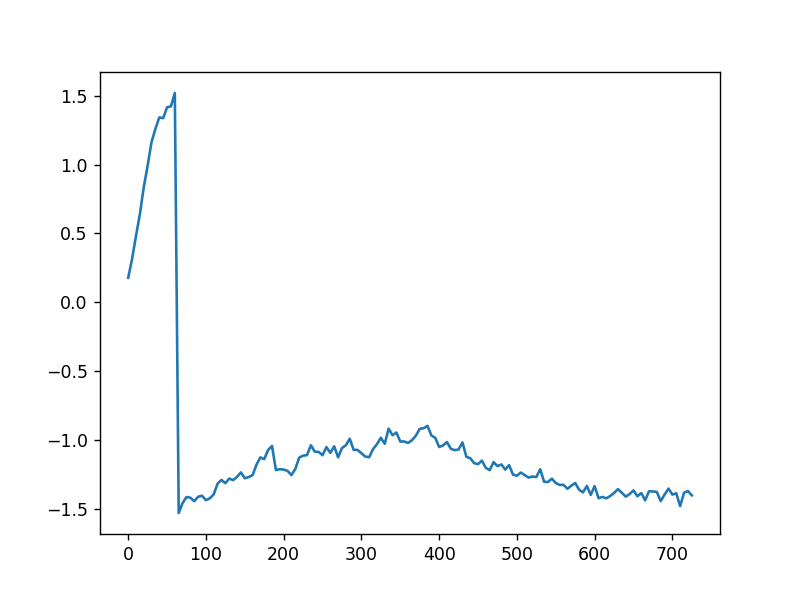

In [73]:
q_target, which, tcali = q6, measure.onwhich[0], 200
dragcoef = None
tdelay = np.arange(0,800,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.ramseyZpulse, (q_target,measure,tdelay,which,tcali,dragcoef), tags=[q_target.q_name], max=len(tdelay))
t_rz, poplist_rz = await job.done()
coordinate = [[1-2*j[i] for i in range(2)] for j in poplist_rz]
theta = np.array([np.arctan(i[1]/i[0]) for i in coordinate])
plt.figure()
plt.plot(t_rz,theta)
plt.show()

In [59]:
j = 0
theta_new = []
theta_new.append(theta[0])
for i,j in enumerate(theta[1:],start=1):
    if theta_new[i-1]-j>np.pi/2:
        theta_new.append(j+np.pi/2)
    if theta_new[i-1]-j<-np.pi/2:
        theta_new.append(j-np.pi/2)

NameError: name 'theta' is not defined

# RamseyZpulse_chen

In [640]:
q_target, which, tcali = q6, measure.onwhich[0], 190
dragcoef = None
tdelay = np.arange(0,400,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
t_rz,poplist_rz = [], []
for nozpulse in [True,False]:
    job = Job(mr.ramseyZpulse_chen, (q_target,measure,tdelay,which,tcali,dragcoef,nozpulse), tags=[q_target.q_name], max=len(tdelay))
    t, pop = await job.done()
    t_rz.append(t)
    poplist_rz.append(pop)

Output()

Output()

In [414]:
def test(theta):
    j = 0
    theta_new = []
    theta_new.append(theta[0])
    for i,j in enumerate(theta[1:],start=1):
        while 1:
            if theta_new[i-1]>j+0.8:
                j += np.pi
            else:
                break
        theta_new.append(j)
    return np.array(theta_new)

<IPython.core.display.Javascript object>


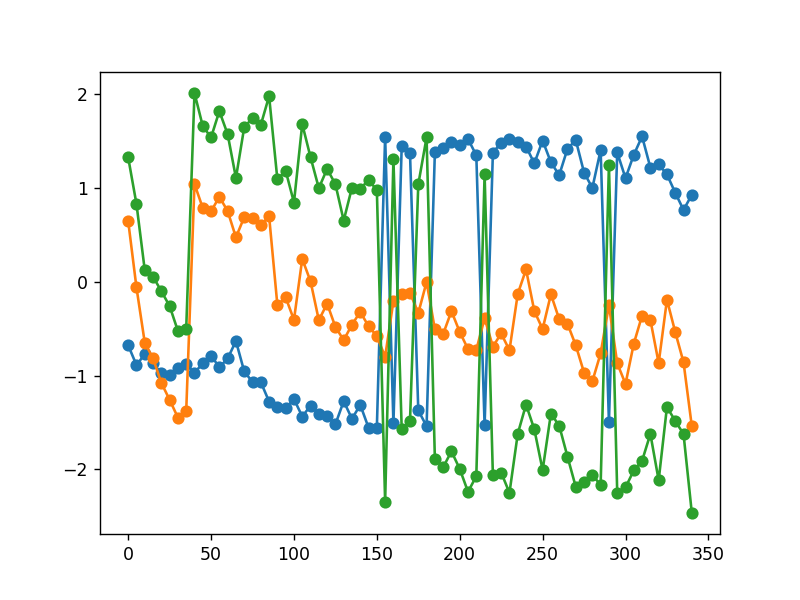

In [641]:
plt.figure()
t = t_rz[0][:,0]
pop_ref, pop_rz = poplist_rz[0], poplist_rz[1]
coordinate_ref = [[1-2*j[i] for i in range(2)] for j in pop_ref]
coordinate_rz = [[1-2*j[i] for i in range(2)] for j in pop_rz]
theta_ref = np.array([np.arctan(i[1]/i[0]) for i in coordinate_ref])
theta_rz = np.array([np.arctan(i[1]/i[0]) for i in coordinate_rz])

# theta_ref = test(theta_ref)
plt.plot(t,theta_ref,'-o')
# theta_rz = test(theta_rz)
plt.plot(t,theta_rz,'-o')
deltatheta = theta_rz - theta_ref
# deltatheta = test(deltatheta)
plt.plot(t,deltatheta,'-o')
plt.show()

In [398]:
np.shape(coordinate_rz)

(84, 2)

In [400]:
c 

[[0.163370253164557, 0.5688291139240507, 0],
 [0.08267405063291144, 0.5280854430379747, 0],
 [0.09335443037974689, 0.5704113924050633, 0],
 [0.08504746835443033, 0.5862341772151899, 0],
 [0.24564873417721522, 0.5803006329113924, 0],
 [0.24683544303797467, 0.5751582278481013, 0],
 [0.2784810126582279, 0.5510284810126582, 0],
 [0.02373417721518989, 0.4489715189873418, 0],
 [0.015427215189873444, 0.5344145569620253, 0],
 [-0.028481012658227778, 0.5284810126582278, 0],
 [0.15625, 0.5569620253164558, 0],
 [0.153876582278481, 0.5427215189873418, 0],
 [0.06685126582278478, 0.45767405063291144, 0],
 [0.27966772151898733, 0.4932753164556962, 0],
 [0.12223101265822789, 0.492879746835443, 0],
 [0.0035601265822784445, 0.4058544303797469, 0],
 [-0.015427215189873333, 0.461629746835443, 0],
 [-0.054193037974683556, 0.4612341772151899, 0],
 [-0.18868670886075956, 0.2689873417721519, 0],
 [-0.11867088607594933, 0.2954905063291139, 0],
 [-0.1586234177215189, 0.3817246835443038, 0],
 [-0.202136075949367

In [397]:
np.arctan(coordinate_rz[9][1]/coordinate_rz[9][0])

-1.5169561948215944

<IPython.core.display.Javascript object>


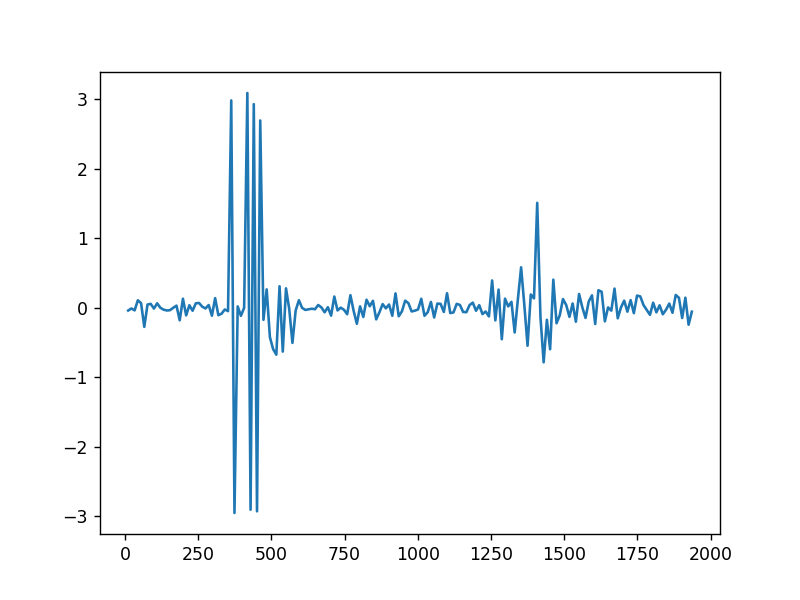

In [233]:
plt.figure()
deltatheta = np.diff(deltatheta)
plt.plot(t[1:],deltatheta)
plt.show()

# Zpulse_XY

Output()

<IPython.core.display.Javascript object>


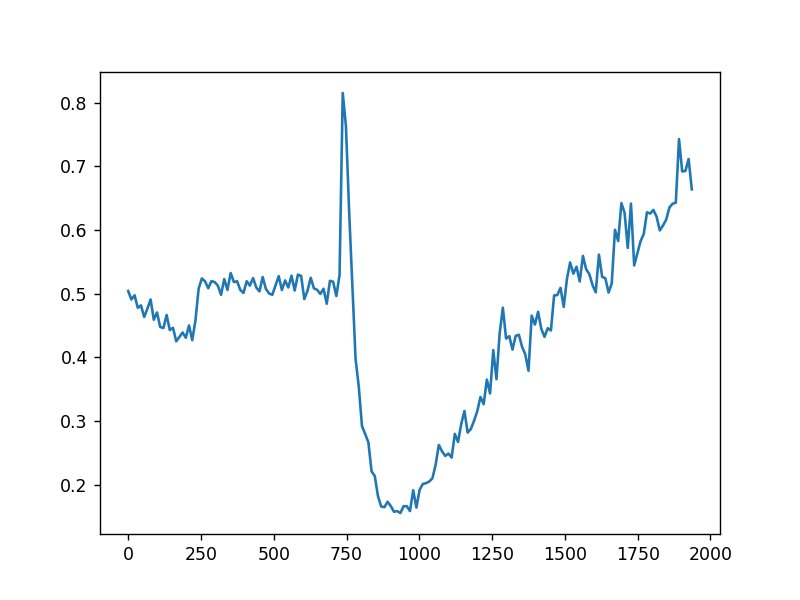

In [178]:
q_target, which, tcali = q6, measure.onwhich[0], 300
dragcoef = 1.4/q_target.alpha/2/np.pi
tdelay = np.arange(0,2000,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.zPulse_XY, (q_target,measure,tdelay,which,tcali,dragcoef), tags=[q_target.q_name], max=len(tdelay))
t_xy, pop_xy = await job.done()
plt.figure()
plt.plot(t_xy,pop_xy)
plt.show()

<IPython.core.display.Javascript object>


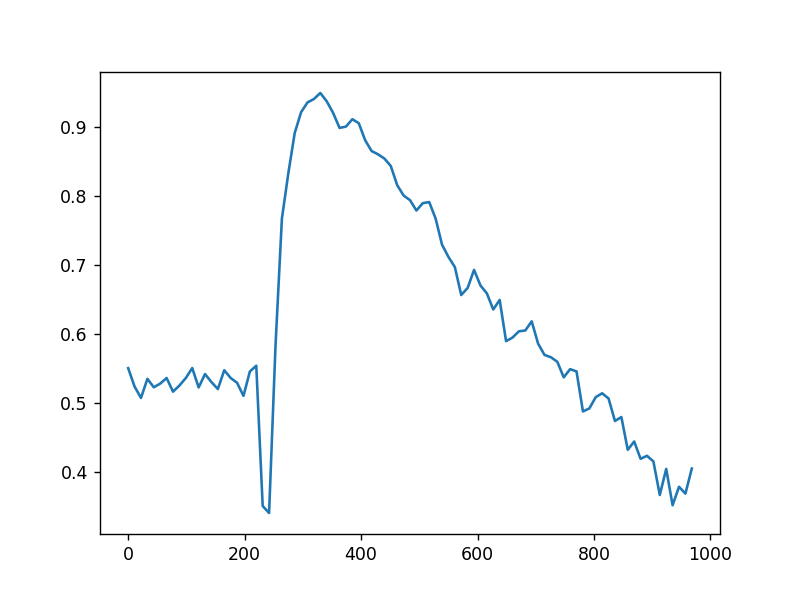

In [168]:
plt.figure()
plt.plot(t_xy,pop_xy)
plt.show()

# T1

Output()

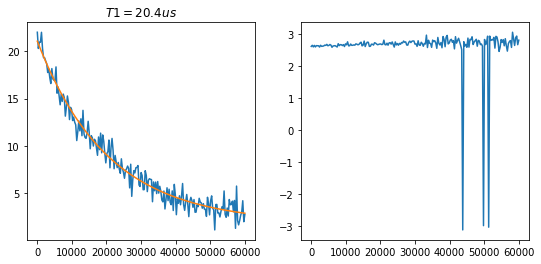

In [61]:
t_T1, q_target = np.linspace(0,60000,201,endpoint=True,dtype=int), q3
# await psg_ex1.setValue('Moutput','OFF')
job = Job(mr.T1, (q_target,measure,t_T1,True), tags=[tag], max=500,avg=True)
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1fus$'%(1/T1/1000))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

<IPython.core.display.Javascript object>


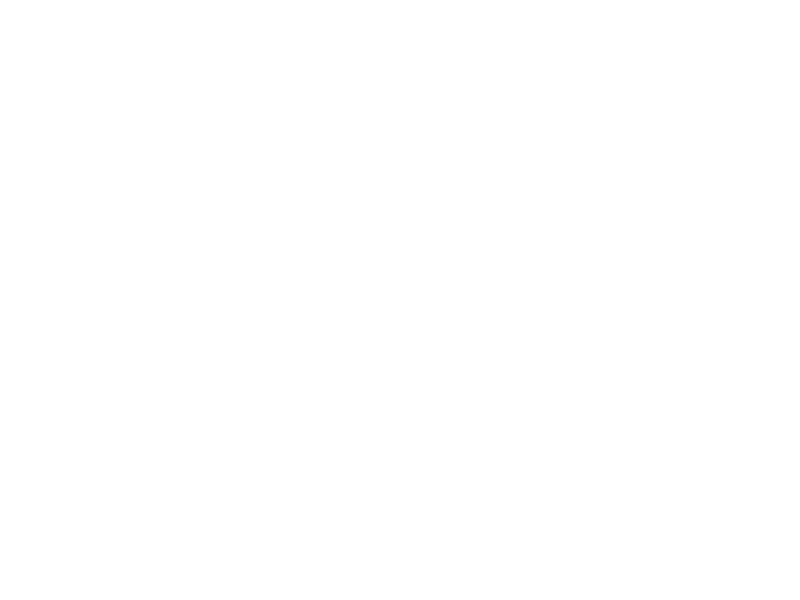

In [308]:
# t_T1, q_target = np.logspace(0,4.9,201,endpoint=True), q5
# # await psg_ex1.setValue('Moutput','OFF')
# T = []
# for i in range(48):
#     comwave = True if i == 0 else False
#     job = Job(mr.T1, (q_target,measure,t_T1,comwave), tags=[q_target.q_name], max=500,avg=True)
#     t_t, s_t = await job.done()
#     A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
#     T.append(T1)
#     time.sleep(60*10)
plt.figure()
plt.plot(range(48),1/np.array(T),'-o',markersize=2)
plt.show()

In [ ]:
q1 = q1._replace(T1=T1)

In [306]:
T

[2.7231890858679188e-05,
 2.9756217769056156e-05,
 2.8325882635911012e-05,
 3.0239283067453666e-05,
 3.2396201229150536e-05,
 2.858684145733197e-05,
 2.8708394008381623e-05,
 3.1290432531509416e-05,
 3.1254117758158547e-05,
 3.246962711833749e-05,
 3.316236417578978e-05,
 3.4515488567125156e-05,
 3.5308237789406365e-05,
 3.418889965141075e-05,
 3.615666555438153e-05,
 3.1093916053014106e-05,
 3.248394611364649e-05,
 3.355464314514516e-05,
 3.329997359820738e-05,
 3.5395364423073406e-05,
 3.0041638229643572e-05,
 3.8591638388035424e-05,
 3.224388255217207e-05,
 2.838512155755783e-05,
 3.1699917156811566e-05,
 3.1306607503612263e-05,
 3.4929785855805814e-05,
 3.609834044486405e-05,
 3.3575550466441455e-05,
 4.937053029121134e-05,
 4.72498942814237e-05,
 5.127553513516364e-05,
 5.2307617262674485e-05,
 4.202326900693847e-05,
 3.8192305518714944e-05,
 3.843944721507662e-05,
 3.98939945618401e-05,
 3.686848343985107e-05,
 3.964898424181794e-05,
 3.5793566349109016e-05,
 3.372216193778482e-0

# Ramsey

Output()

(10.831466460681446, 12.046658693016001, 30000, 1533.5031330684465, 0.0034825870646766166, 0)


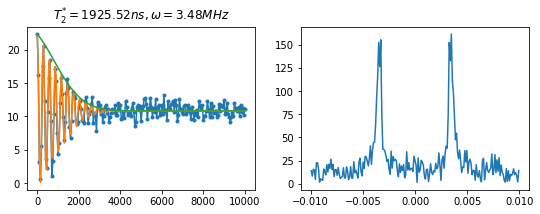

In [62]:
t_Ramsey, q_target, num = np.linspace(0,10000,201), q3, 0
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

job = Job(mr.Ramsey, (q_target,measure,t_Ramsey,True), tags=[q_target.q_name], max=500,avg=True)
t_ram, s_ram = await job.done()
x, y = t_ram[:,num], (s_ram[:,num])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(t_ram,np.abs(s_ram),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fns,\omega=%.2fMHz$'%(T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [175]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))

In [463]:
q10 = q10._replace(f_ex=(np.array([f-w*1e9])-200e6+3e6))

Output()

<IPython.core.display.Javascript object>


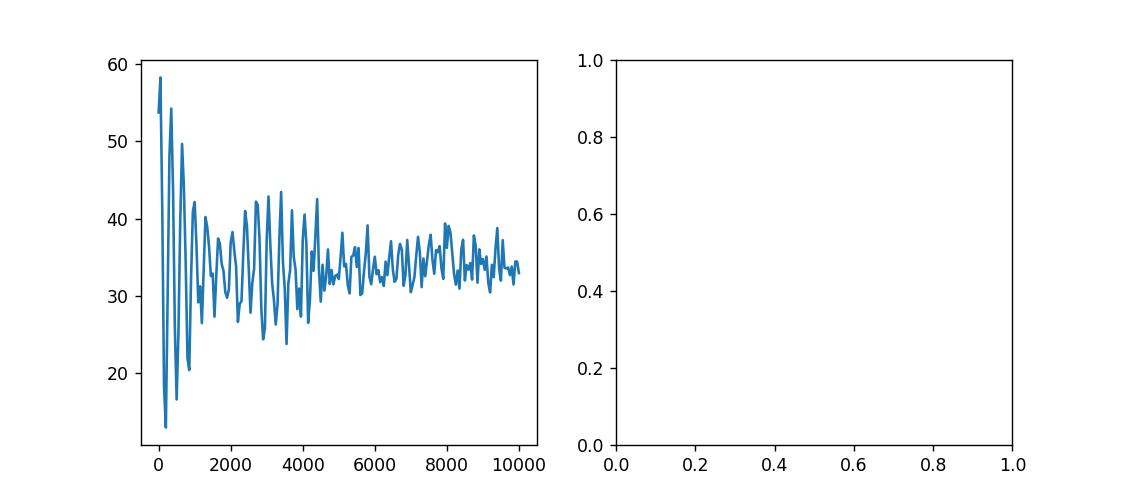

In [50]:
t_Ramsey, q_target = np.linspace(0,10000,201), q3
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.Ramsey_waveform, (q_target,measure,t_Ramsey), tags=[q_target.q_name], max=len(t_Ramsey))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

In [37]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': [3], 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex1', 'com': 'com5'}, T_bias=[1.762, 0.064], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.05, zpulse=None, f_lo=array([6.53078e+09]), delta=array([50000000.]), f_ex=array([3.90881343e+09]), delta_ex=array([1.1e+08]), alpha=268000000.0, power_ex=60, power_rabi=0, pi_len=8.54, T1=23016.178849233776, state=[{'q2': {'offset': -1.1, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': 1.75, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': -1.0, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': 0.12, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': -1.0, 'load': 'high Z', 'error': '+0'}, 'q5':

# SpinEcho

Output()

(11.555201584032615, 14.085356895681347, 100000, 8859.764858199762, 0.0029900332225913625, 0)


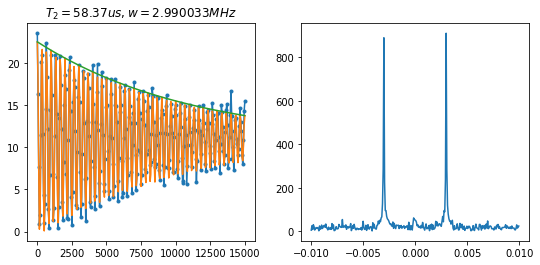

In [64]:
t_spin, q_target = np.linspace(0,15000,301), q3
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

job = Job(mr.SpinEcho, (q_target,measure,t_spin,1,'CPMG',True), tags=[tag], max=500,avg=True)
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], s_sp[:,0]
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=100000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}=%.2fus,w=%fMHz$'%(np.abs(T2/1000),w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

# CrossTalk矫正

In [ ]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [ ]:
z_crosstalk

# 直流crosstalk矫正

In [574]:
dc_crosstalk = np.eye(10)

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
await psg_trans.setValue('Power',13)
mr.Att_Setup(measure,'com8').Att(25)
# await cw.modulation_ex(q1,measure)
for v, k in enumerate(bits):
    q_target = k
    for i,j in enumerate(bits):
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.dcCrosstalk, (q_target,q_bias,measure), tags=[tag], max=40)
            v_bias, s_sc = await job.done()
            x, y = v_bias[:,0], np.abs(s_sc[:,0])
            a,b,c,d,band = op.Lorentz_Fit().fitLorentz(x,y)
            ratio = -b/0.005
            dc_crosstalk[eval(q_target.q_name[1:]),eval(q_bias.q_name[1:])] = ratio
            z = a/(1.0+c*(x-b)**2)+d
            plt.figure()
            plt.plot(x,y)
            plt.plot(x,z)
            plt.title(tag+f'ratio={ratio}')
            plt.savefig(r'D:\skzhao\file_name\figure\%s.png'%tag)
            plt.close()
            clear_output()
            await mr.InitInst(measure,psgdc=True,awgch=False)
    await mr.InitInst(measure,psgdc=True,awgch=False)

# 普矫正

In [ ]:
v_rabi = np.linspace(-0.04,0.04,201)
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len(v_rabi),['Readout_Q']*len(v_rabi)]

In [ ]:
bits = [q2,q3,q4,q5]
count = 0
for v, k in enumerate(bits):
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_ex)
    await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits):
        comwave = True if count == 0 else False
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.crosstalkSpec, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),comwave), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await mr.InitInst(measure,psgdc=False,awgch=True)
            count += 1
    await mr.InitInst(measure,psgdc=True,awgch=True)

In [ ]:
measure.n = 1

# 真空拉比

Output()

<IPython.core.display.Javascript object>


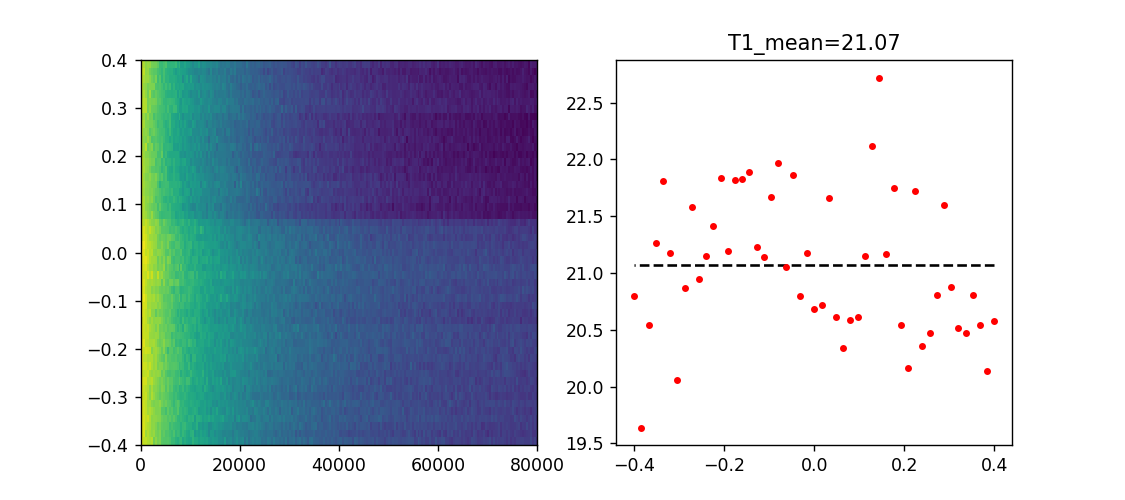

In [416]:
q_target, t_rabi, v_rabi = q5, np.linspace(0,80000,201), np.linspace(-0.4,0.4,51)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.vRabi, (q_target,measure,t_rabi,v_rabi), tags=[q_target.q_name], max=len(v_rabi))
vv, tv, sv = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = vv[:,0],tv[:,:,0], np.abs(sv[:,:,0])
t1 = []
for i in range(len(v_rabi)):
    A, B, T1 = op.Exp_Fit().fitExp(y[i,:],np.abs(s[i,:]))
    t1.append(round(1/T1/1e3,2))
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
axes[1].plot(x,t1,'r.')
axes[1].hlines(np.mean(t1),np.max(x),np.min(x),'k','--')
axes[1].set_title('T1_mean=%.2f'%np.mean(t1))
plt.show()

In [353]:
np.shape(vv)

(2, 1)

In [ ]:
def vRabi(qubit,measure,t_rabi,v_rabi)

# 二维谱

In [53]:
freq = np.arange(3,4.5,0.001)*1e9
bits = [q3,q8]
await psg_trans.setValue('Power',5)
await measure.attinst['com8'].set_att(20)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
#     await mr.jpa_switch(measure,'ON')
    print(i.q_name)
#     if k == 0:
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
#     elif k == len(bits_target)-1:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#     else:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
    job = Job(mr.spec2d, (i,measure,freq,None), tags=[i.q_name], max=36)
    v_s2, f_s2, s_s2 = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [28]:
q6

qubit(q_name='q6', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': [6], 'ex_awg': 'awg134', 'ex_ch': [4, 8], 'ex_lo': 'psg_ex1', 'com': 'com3'}, T_bias=[1.759, 0.3], specfunc=2.50097887434493*sqrt(Abs(cos(2.31494361107522*x + 6.4569418462785))) + 1.49302240016532, bias=-0.9, zpulse=None, f_lo=array([6.6e+09]), delta=array([50000000.]), f_ex=array([8.403e+09]), delta_ex=array([1.1e+08]), alpha=268000000.0, power_ex=60, power_rabi=36, pi_len=39, T1=None, state=[{'q2': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.14, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': 1.75, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q5': {'offset': 0.0, 'load'

In [ ]:
np.linspace(-q3.T_bias[0]*0.3,q3.T_bias[0]*0.3,31) + q3.T_bias[1] 

In [111]:
q5

qubit(q_name='q5', inst={'dc': 'dc15', 'z_awg': 'awg131', 'z_ch': 5, 'ex_awg': 'awg133', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex1', 'com': 'com13'}, T_bias=[1.798, 0.064], specfunc=-24.2491131683623*cos(0.166901270293213*pi*x + 3.10635672710517) - 20.2024069833602, bias=-0.15, zpulse=None, f_lo=array([6.55858e+09]), delta=array([50000000.]), f_ex=array([3.92e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=13, pi_len=32.135, T1=None, state=[{'dc01': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 1.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': 0.015, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0, 'load': 'high Z', 'error': '+0'}, 'dc15': {'offset': -0.15,

# RB_waveform

## reference

In [569]:
mlist, q_target, len_data, which, gate = np.logspace(0.4,2.8,16,dtype=int), q10, 30, measure.offwhich[0], False
dragcoef = None
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB_waveform,(q_target,measure,mlist,len_data,which,200e6,dragcoef,gate),tags=[q_target.q_name,'reference','nodrag'],no_bar=True)
n_RBw, pop_RBw = await job.done()

Output()

In [570]:
mlist, q_target, len_data, which, gate = np.logspace(0.4,2.8,16,dtype=int), q10, 30, measure.offwhich[0], False
dragcoef = -0.7/q_target.alpha/2/np.pi
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB_waveform,(q_target,measure,mlist,len_data,which,200e6,dragcoef,gate),tags=[q_target.q_name,'reference'],no_bar=True)
n_RBw, pop_RBw = await job.done()

Output()

<IPython.core.display.Javascript object>


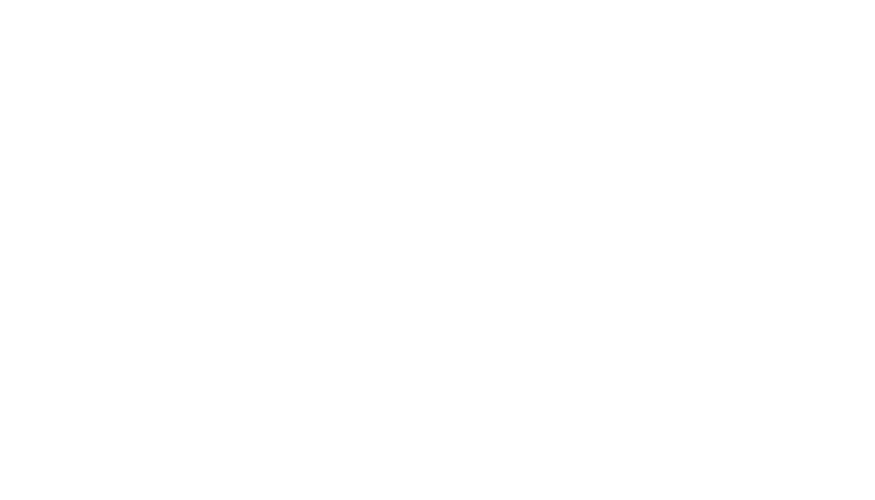

In [236]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label='reference')
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.title('p=%f'%p)
plt.show()

## gate

In [366]:
mlist, q_target, len_data, which = np.logspace(0.4,2.8,16,dtype=int), q6, 30, measure.offwhich[0]
dragcoef = 0/q_target.alpha/2/np.pi

await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
for gate in ['2','3','4','5','6','7'][:3]:
    job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,200e6,dragcoef,gate), tags=[q_target.q_name,gate],no_bar=True)
    n_RBw, pop_RBw = await job.done()
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

Output()

Output()

Output()

<IPython.core.display.Javascript object>


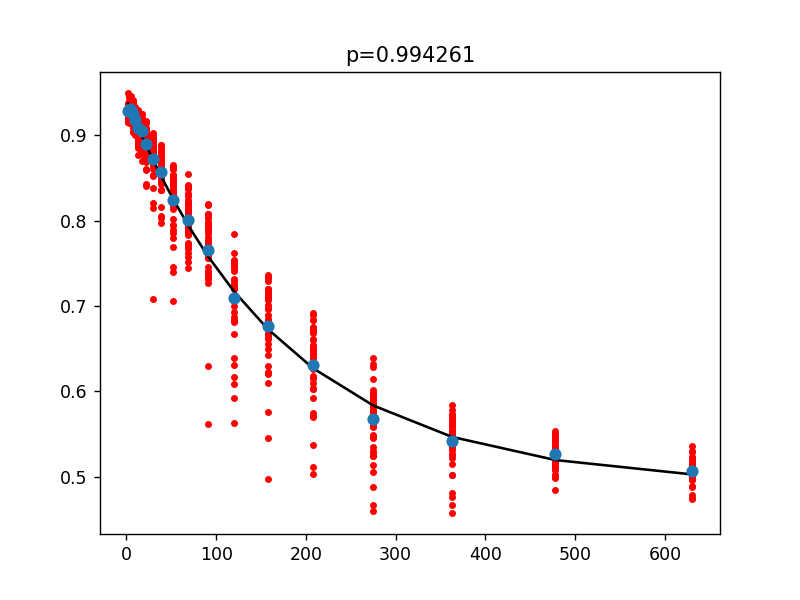

In [64]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label=gate)
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.set_title('p=%f'%p)
plt.show()

In [70]:
Pref, Pgate, d = 0.9946, 0.994261, 2**(1)
Rgate = (1-Pgate/Pref)*(1-1/d)
Rgate

-0.003516601051131496

# 单比特tomo

In [551]:
q_target, which = q6, measure.onwhich
dragcoef = None
t_rabi = np.linspace(1,30,31)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.tomo, (q_target,measure,t_rabi,which,dragcoef), tags=[q_target.q_name], max=len(t_rabi))
t_tomo, poplist = await job.done()

Output()

In [553]:
poplist

array([[0.4414557 , 0.68255538, 0.09434335],
       [0.44165348, 0.74643987, 0.14893196],
       [0.42464399, 0.84355222, 0.27650316],
       [0.44719146, 0.88627373, 0.40842563],
       [0.40051424, 0.89181171, 0.40150316],
       [0.38172468, 0.87440665, 0.58049842],
       [0.43908228, 0.7903481 , 0.7252769 ],
       [0.44481804, 0.71064082, 0.81863133],
       [0.38548259, 0.55439082, 0.89121835],
       [0.42780854, 0.42147943, 0.89339399],
       [0.47982595, 0.28322785, 0.84196994],
       [0.43413766, 0.17246835, 0.77907437],
       [0.45193829, 0.10324367, 0.65288766],
       [0.46677215, 0.05953323, 0.49545095],
       [0.45431171, 0.0820807 , 0.34572785],
       [0.47290348, 0.14102057, 0.23457278],
       [0.46756329, 0.23971519, 0.15268987],
       [0.47606804, 0.37321994, 0.0846519 ],
       [0.47448576, 0.51681171, 0.06784019],
       [0.45945411, 0.63073576, 0.09236551],
       [0.47883703, 0.75613133, 0.17780854],
       [0.47606804, 0.84177215, 0.28560127],
       [0.

In [554]:
data = [[1-2*j[i] for i in range(3)] for j in poplist]
data

[[0.11708860759493667, -0.3651107594936709, 0.8113132911392404],
 [0.11669303797468356, -0.4928797468354431, 0.7021360759493671],
 [0.15071202531645567, -0.6871044303797469, 0.446993670886076],
 [0.10561708860759489, -0.7725474683544304, 0.18314873417721522],
 [0.19897151898734178, -0.7836234177215189, 0.196993670886076],
 [0.23655063291139244, -0.7488132911392404, -0.160996835443038],
 [0.12183544303797467, -0.5806962025316456, -0.45055379746835444],
 [0.11036392405063289, -0.4212816455696202, -0.637262658227848],
 [0.22903481012658233, -0.10878164556962022, -0.7824367088607596],
 [0.1443829113924051, 0.15704113924050633, -0.7867879746835442],
 [0.04034810126582278, 0.43354430379746833, -0.6839398734177216],
 [0.13172468354430378, 0.6550632911392404, -0.5581487341772151],
 [0.096123417721519, 0.7935126582278481, -0.3057753164556962],
 [0.06645569620253167, 0.8809335443037974, 0.009098101265822778],
 [0.091376582278481, 0.8358386075949367, 0.30854430379746833],
 [0.054193037974683556, 

In [401]:
np.savez('z.npz',data=c)

In [284]:
x = [['I1','I2'],['Q1','Q2']]*2

In [288]:
[x[0]*2,x[1]*2]

[['I1', 'I2', 'I1', 'I2'], ['Q1', 'Q2', 'Q1', 'Q2']]

In [287]:
x

[['I1', 'I2'], ['Q1', 'Q2'], ['I1', 'I2'], ['Q1', 'Q2']]